In [1]:
##### Set The Directory
%cd "C:\Users\rahil.bagheri\OneDrive - REI Systems Inc\Desktop"

C:\Users\rahil.bagheri\OneDrive - REI Systems Inc\Desktop


Taken Steps:

Step 1) Loading the Data and provide some descriptive statistics   
Step 2) Data Exploration, Descriptive Statistics of features  
Step 3) Data Wrangling - Duplicate Transactions  
Step 4) Predictive Modeling  
Step 4-1) Data visualization and exploration for predictive purposes  
Step 4-2) Outlier Detection  
Step 4-3) Re-Encode Categorical Features  
Step 4-4) Imbalanced Data  
Step 4-5) Split the data to train and test and Select appropriate Classifiers  
Step 4-6) Oversampling
Step 4-7) Undersampling  
Step 4-8) Evaluate the Models' Prediction and Interpret the results 
Step 5) Potential Improvements 

Step 1) Loading the Data and provide some descriptive statistics 

At this step, I explored the structure of the data, the number of records and features, and some additional basic summary statistics. The zipped data is saved on my local. I read the JSON file and saved it as a pandas data frame named "Data".

In [2]:
##### Libraries 
import os
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
from zipfile import ZipFile
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler
import itertools

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
#from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold,StratifiedShuffleSplit
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
# Open the zipped file and read the Json file
zip_file = ZipFile('transactions.zip')
Data = pd.read_json(zip_file.open('transactions.txt'), lines=True)

Step 2: Data Exploration 

The transaction dataset, Data, has 786363 records and 29 columns. Some of these columns have blanks that are replaced by "Nan" at this step for further analysis. Some other features have 100% missing values like "echoBuffer", "merchantCity", "merchantZip", "posOnPremises" and "recurringAuthInd". These columns are removed from the rest of the analysis. You can find the list of all of them in the following cell's result. 

Some features are numerical like "transactionAmount", "availableMoney", "creditLimit". Most of the customers have a 5000 credit limit, about 201863 records. 

Some are binary like "isFraud" and "cardPresent". Please see the result of the next cell for more information about each data element and its structures. 

Out of 786363 number of transactions, 773946 are not fraud and 12417 are a fraud. It means the data is highly imbalanced and for predictive analysis, it has to be considered. I will explain more about it later.  

Some other features are unique IDs like "accountNumber", "cardCVV", "cardLast4Digits", and "customerId". Customers' ID is equal to their Account Number and for each specific account, there might be multiple card CVV which makes sense.

Some other features are time and date values. For example, Date and time of transaction, "dateOfLastAddressChange" and "currentExpDate". These transactions are from 2016 from Jan to Dec. 

Most of the transactions, Fraud and Non_fraud, happened in the USA. Comparing both kinds of transactions, Mexico has more Fraud than Nonfraud, about 0.12% more. 

Number of rows in raw transactional data is : 786363
Number of rows in raw transactional data is : 29
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The structure of each column is: accountNumber                 int64
accountOpenDate              object
acqCountry                   object
availableMoney              float64
cardCVV                       int64
cardLast4Digits               int64
cardPresent                    bool
creditLimit                   int64
currentBalance              float64
currentExpDate               object
customerId                    int64
dateOfLastAddressChange      object
echoBuffer                   object
enteredCVV                    int64
expirationDateKeyInMatch       bool
isFraud                        bool
merchantCategoryCode         object
merchantCity                 object
merchantCountryCode          object


Text(0.5, 1.0, 'Count of missing values for each feature')

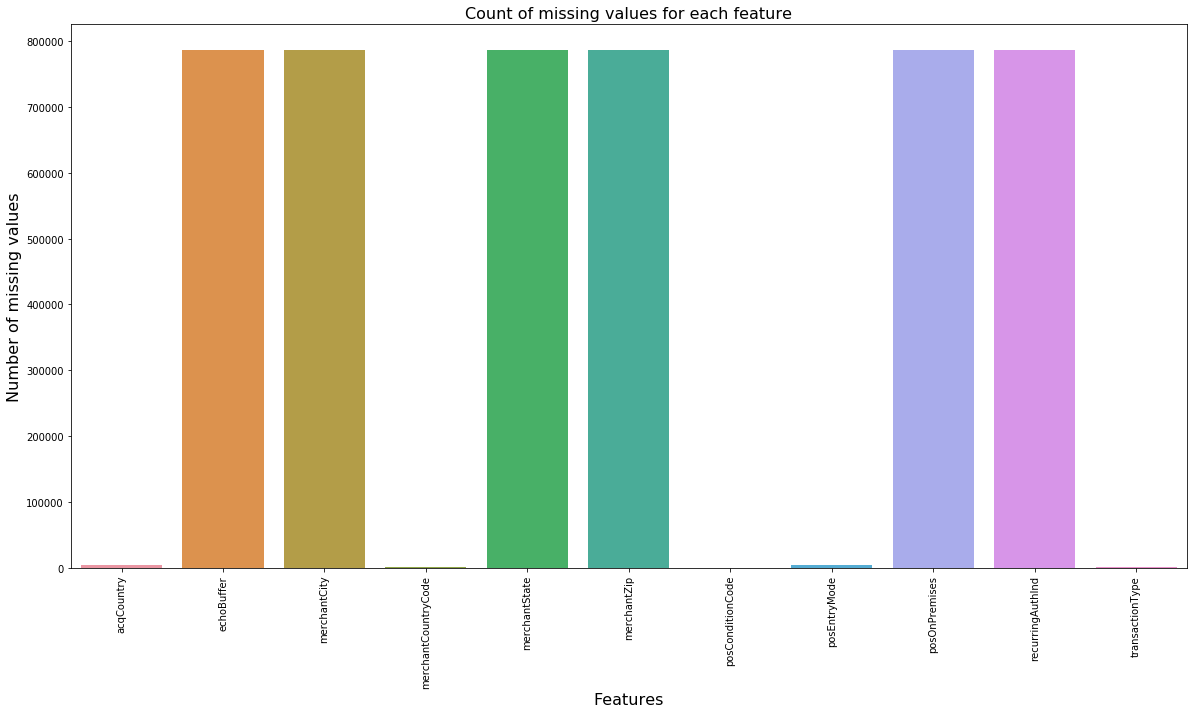

In [4]:
# number of rows and columns 
print('Number of rows in raw transactional data is : {}'.format(Data.shape[0]))
print('Number of rows in raw transactional data is : {}'.format(Data.shape[1]))
print('---' * 60)
print('The structure of each column is: {}.'.format(Data.dtypes))
# replace blanks with Nan 
Data.replace('', np.nan, inplace=True)

# check how many Nans are already in each column
Null_Percentage = Data.isnull().sum()/len(Data)*100
print('The percentage of missing values in each column is: {}.'.format(Null_Percentage))
print('---' * 60)
# find the number of total missing values 
print('The number of total missing values is: {}.'.format(Data.isnull().sum().sum()))

# barplot of number of missing values 
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.yticks()
sns.barplot(x=Data.isnull().sum()[Data.isnull().sum().nonzero()[0]].index,y=Data.isnull().sum()[Data.isnull().sum().nonzero()[0]].values)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Number of missing values', fontsize=16)
plt.title('Count of missing values for each feature', fontsize=16)

As I mentioned before, some features are numerical. At this step, I explored them more to see how variables are distributed by finding their 5 number summary statistics. For example, "transactionAmount" is skewed to right for both Fraud and Non-Fraud transactions (Mean > Median). The money spent at each transaction has pretty big outliers since the 75% percentile is 191.48 dollars and the maximum money spent was 2011.54. It has to be taken care of in the next steps. It total, all the numerical variables are skewed to the right. 
Out of all Fraud transactions, 39.768% were by online retail merchant category. 

Descriptive Statistics for Transaction Amount :


count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Descriptive Statistics for Current Balance : 


count    786363.000000
mean       4508.739089
std        6457.442068
min           0.000000
25%         689.910000
50%        2451.760000
75%        5291.095000
max       47498.810000
Name: currentBalance, dtype: float64

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Descriptive Statistics for Available Money :


count    786363.000000
mean       6250.725369
std        8880.783989
min       -1005.630000
25%        1077.420000
50%        3184.860000
75%        7500.000000
max       50000.000000
Name: availableMoney, dtype: float64

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


False    773946
True      12417
Name: isFraud, dtype: int64

Text(0.5, 1.0, 'Distribution of Fraud and Non Fraud Transactions')

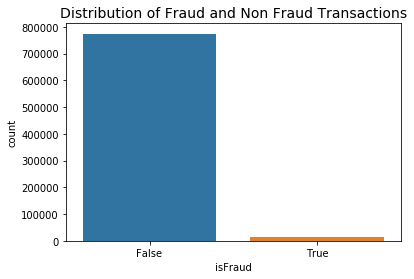

In [5]:
# see the structure of numerical features 
print('Descriptive Statistics for Transaction Amount :')
display(Data.transactionAmount.describe())
print('---' * 60)
print('Descriptive Statistics for Current Balance : ')
display(Data.currentBalance.describe())  
print('---' * 60)
print('Descriptive Statistics for Available Money :')
display(Data.availableMoney.describe()) 
print('---' * 60)
display(Data['isFraud'].value_counts())
sns.countplot('isFraud', data=Data)
plt.title('Distribution of Fraud and Non Fraud Transactions', fontsize=14)

In [6]:
# description of all data elements. Some might not be relevant.
Data.describe(include = 'all')

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
count,7.863630e+05,786363,781801,786363.000000,786363.000000,786363.000000,786363,786363.000000,786363.000000,786363,...,786363,0.0,0.0,785954,782309,0.0,0.0,786363.000000,786363,785665
unique,NaN,1820,4,NaN,NaN,NaN,2,NaN,NaN,165,...,2490,NaN,NaN,3,5,NaN,NaN,NaN,776637,3
top,NaN,2014-06-21,US,NaN,NaN,NaN,False,NaN,NaN,03/2029,...,Uber,NaN,NaN,01,05,NaN,NaN,NaN,2016-12-25T14:04:15,PURCHASE
freq,NaN,33623,774709,NaN,NaN,NaN,433495,NaN,NaN,5103,...,25613,NaN,NaN,628787,315035,NaN,NaN,NaN,4,745193
mean,5.372326e+08,NaN,NaN,6250.725369,544.467338,4757.417799,NaN,10759.464459,4508.739089,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.985791,NaN,NaN
std,2.554211e+08,NaN,NaN,8880.783989,261.524220,2996.583810,NaN,11636.174890,6457.442068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.725569,NaN,NaN
min,1.000881e+08,NaN,NaN,-1005.630000,100.000000,0.000000,NaN,250.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,3.301333e+08,NaN,NaN,1077.420000,310.000000,2178.000000,NaN,5000.000000,689.910000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.650000,NaN,NaN
50%,5.074561e+08,NaN,NaN,3184.860000,535.000000,4733.000000,NaN,7500.000000,2451.760000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.900000,NaN,NaN
75%,7.676200e+08,NaN,NaN,7500.000000,785.000000,7338.000000,NaN,15000.000000,5291.095000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.480000,NaN,NaN


In [7]:
# Remove columns with all missing values. There were some columns with 100% missing values
missing_columns = Null_Percentage
remove = missing_columns[missing_columns == 100.00].index
Data = Data.drop(remove,axis=1)

print('These columns are removed from the data due to having more than 40% missing values {}.'.format(remove))
# remove them from data
Data = Data[Data.index.isin(remove) == False]

These columns are removed from the data due to having more than 40% missing values Index(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip',
       'posOnPremises', 'recurringAuthInd'],
      dtype='object').


Step 2: Exploratory Data Analysis


In [8]:
# histogram plot of the processed amounts of each transaction including duplicated transactions
def distribution_plot_all (data,x):
    '''
    This function plot the distribution of any numerical variable named x.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.distplot(data[x], color='red', bins=100)
    plt.title('Distribution Of %s'%x, fontsize=14)
    plt.xlabel(x, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    
    

In [9]:
# histogram plot of the processed amounts of each transaction including duplicated transactions seperated for 
# both Fraud and No-Fraud transactions 

def distribution_plot_separate (data,x):
    '''
    This function plot the distribution of x numerical variable for both Fraud and Non-Fraud transactions.
    '''
    df_False = data[data.isFraud == False]
    sns.distplot(df_False[x], label='No Fraud')
    df_True = data[data.isFraud == True]
    sns.distplot(df_True[x], label='Frud')
    # Plot formatting
    plt.legend(prop={'size': 14})
    plt.title('Distribution Of %s'%x,fontsize=14)
    plt.xlabel(x ,fontsize=14)
    plt.ylabel('Density',fontsize=14)

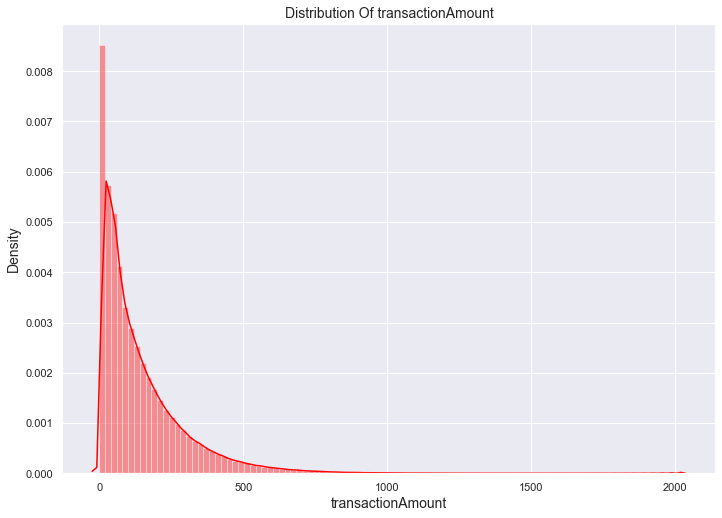

In [10]:
# transaction amount skewed to the right
distribution_plot_all (Data, x = 'transactionAmount')

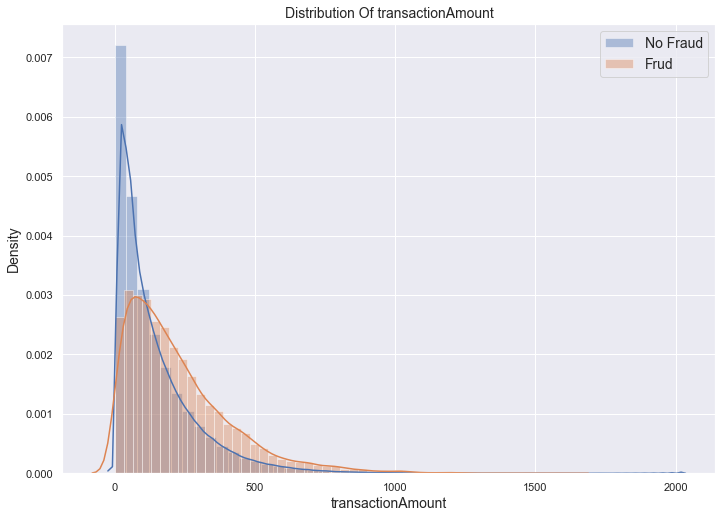

In [11]:
# both skewed to the right
distribution_plot_separate (Data,x = 'transactionAmount')

In [12]:
# ferequency distribution of credit limit. Most customers have a credit limit of 5000 and less have 500 credit limit.
Data.creditLimit.value_counts()

5000     201863
15000    139307
7500      97913
2500      75429
20000     68629
10000     56889
50000     48781
1000      36430
250       34025
500       27097
Name: creditLimit, dtype: int64

In [14]:
# most of transactions happened in the USA. 
display(Data.merchantCountryCode.value_counts())
# America country has the most fraud transactions.
display(Data.groupby(['isFraud']).merchantCountryCode.value_counts(normalize=True).mul(100))

US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64

isFraud  merchantCountryCode
False    US                     99.097250
         MEX                     0.398162
         CAN                     0.306477
         PR                      0.198111
True     US                     98.808269
         MEX                     0.518849
         CAN                     0.453993
         PR                      0.218889
Name: merchantCountryCode, dtype: float64

In [15]:
# Online retail has the most Fraud transactions.  
display(Data.groupby(['isFraud']).merchantCategoryCode.value_counts(normalize=True).mul(100))

isFraud  merchantCategoryCode
False    online_retail           25.482140
         fastfood                14.350355
         entertainment           10.225132
         food                     9.622894
         online_gifts             8.350970
         rideshare                6.442827
         hotels                   4.373303
         fuel                     3.089363
         subscriptions            2.931083
         auto                     2.762208
         health                   2.455210
         personal care            2.439188
         mobileapps               1.936828
         airline                  1.922356
         online_subscriptions     1.429945
         furniture                0.946965
         food_delivery            0.775248
         gym                      0.285420
         cable/phone              0.178565
True     online_retail           39.768060
         online_gifts            12.933881
         rideshare               10.244020
         fastfood       

Step 3) Data Wrangling - Duplicate Transactions

There are some duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span. I developed "find_duplicates" function that extracts these two duplicate types and saves them in a new column added to the dataframe, "duplicateType". 

To identify the reversal ones, I assumed if the "transactionType" is REVERSAL, then the "duplicateType" is also a reversal. 
To identify the multi swipe ones, I assumed, if a card was charged with the same amount by a specific vendor within less than a day, it would be a multi swipe transaction; otherwise, it is a Normal purchase. 

I just want to mention it is my assumption and being more specific requires more domain knowledge. The missing "transactionType" still remains missing in the "duplicateType" column.

The result shows, about 1% of the purchase transactions are multi swipe. And  2.6% of total transactions are reversal. Most of the fraudulent transactions happened while normal purchases, reversal, multi swipe purchases, and address verification by 1.5%, 0.04%, 0.02 and 0.02 respectively. Compared to the number of multi swipe occurrences, the median transaction amount for this group was higher than the others, about 101$. The reversal was the second average money spent and normal was the third. There is no amount for address verification. Also, the median transaction amount for fraudulent and genuine transactions was slightly different. It means using both transaction amount and types will be useful in differentiating fraud transactions from Non fraud. Of course, considering the amount skewness for all the types. 

In [28]:
# grouping the data for each card, merchant and transactions amount
grouped = Data.groupby(['accountNumber','cardCVV','cardLast4Digits','merchantName','transactionAmount'], as_index=False)
# find the time period between each transaction
diff = lambda x: x['transactionDateTime'].diff()

def find_duplicates (data):
    '''
   This function finds the reversal and multi swipe transactions, duplicate transactions, 
   for each account and card. Two columns are added to the input dataset one is "duplicateType" with 4 
   categories Normal, Reversal, Address_Verification, and MultiSwipe_Not_Normal. And the other one is 
   "timediff" that represents the time lag for each account transaction.
    
    '''
    # replace the "T" in the transaction time column with an space.
    data['transactionDateTime'] = data['transactionDateTime'].str.replace('T', ' ')
    # and convert it to Datatime.
    data['transactionDateTime'] =  pd.to_datetime(data['transactionDateTime'], format='%Y-%m-%d %H:%M:%S')
    
    # find the time period between each customer who PURCHASED something with the same amount over and over.
    data.loc[data['transactionType'] == 'PURCHASE', 'time_diff'] = grouped.apply(diff).reset_index(0, drop=True)
    # if the duration between these transactions are more than a day, name them normal otherwise multiswipe  
    data.loc[(data['transactionType'] == 'PURCHASE') | (data['time_diff'] > '0 days'), 'duplicateType'] = 'Normal'
    data.loc[(data['transactionType'] == 'PURCHASE') & (data['time_diff'] <= '1 days'), 'duplicateType'] = 'MultiSwipe_Not_Normal'
    # if the transaction type is Reversal then duplicateType = Reversal
    data.loc[(data['transactionType'] == 'REVERSAL') , 'duplicateType'] = 'Reversal'
    data.loc[(data['transactionType'] == 'ADDRESS_VERIFICATION') , 'duplicateType'] = 'Address_Verification'
    
    
    return(data)



In [29]:
# dataset with dupicate type column 
Data_Duplicates = find_duplicates (Data)

In [30]:
# percentage of duplicated transactions
print('The percentage of duplicate types is:{}.'.format(Data_Duplicates.duplicateType.value_counts(normalize=True)))

The percentage of duplicate types is:Normal                   0.938978
Reversal                 0.025842
Address_Verification     0.025671
MultiSwipe_Not_Normal    0.009509
Name: duplicateType, dtype: float64.


In [41]:
def count_plot_all (data, y):
    '''
    This function plot the count of any categorical variable, y here. 
    '''
    ax = sns.countplot(y=y, data=data)
    total = len(data[y])
    # this for loop is to show the percentage of the plot
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
        
    plt.title('Distribution Of Transaction Types',fontsize=14)
    plt.xlabel('Count',fontsize=14)
    plt.ylabel('Transaction Type',fontsize=14)
    plt.show()

In [42]:
def count_plot_separate (data, y , x):
    '''
    This function plot the barchart of two categorical variables.  
    '''
    ax = sns.countplot(y=y, data=data, hue=x)
    total = len(data[y])
    
    for p in ax.patches:
        percentage = '{:.4f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.title('Distribution Of Transaction Type for Fraud vs Non Fraud',fontsize=14)
    plt.xlabel('Count',fontsize=14)
    plt.ylabel('Transaction Type',fontsize=14)
    ax.legend(loc=4)
    plt.show()

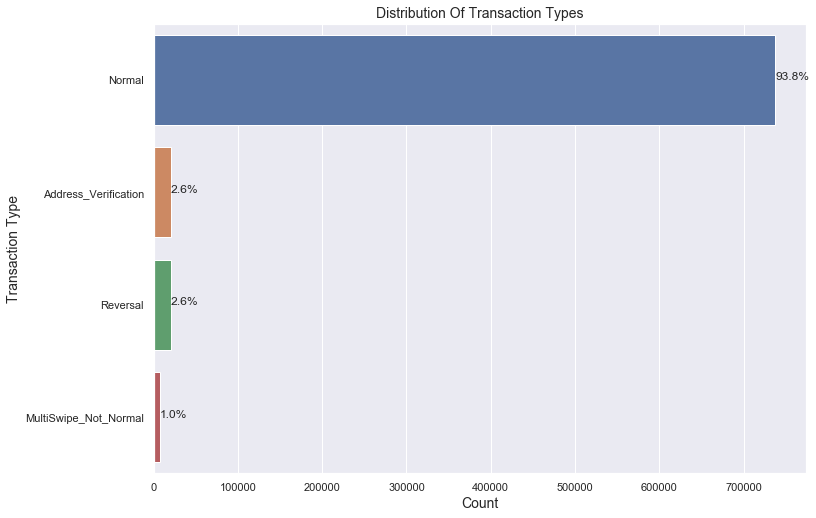

In [20]:
# about 1% of the purchase transactions are multi swipe. And  2.6% of total transactions are reversal. 
count_plot_all (Data_Duplicates, y = "duplicateType")

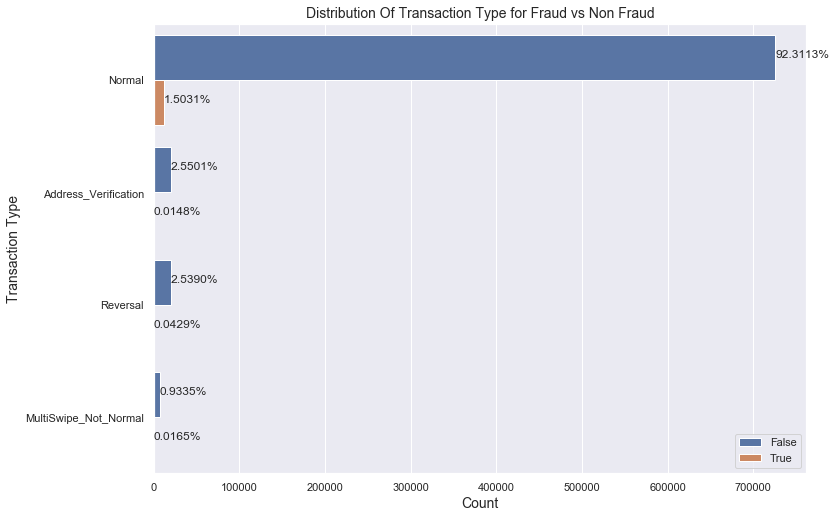

In [21]:
# count plot of different duplicated vs both Fraud and Non Fraud 
count_plot_separate (Data_Duplicates, y = "duplicateType", x="isFraud")

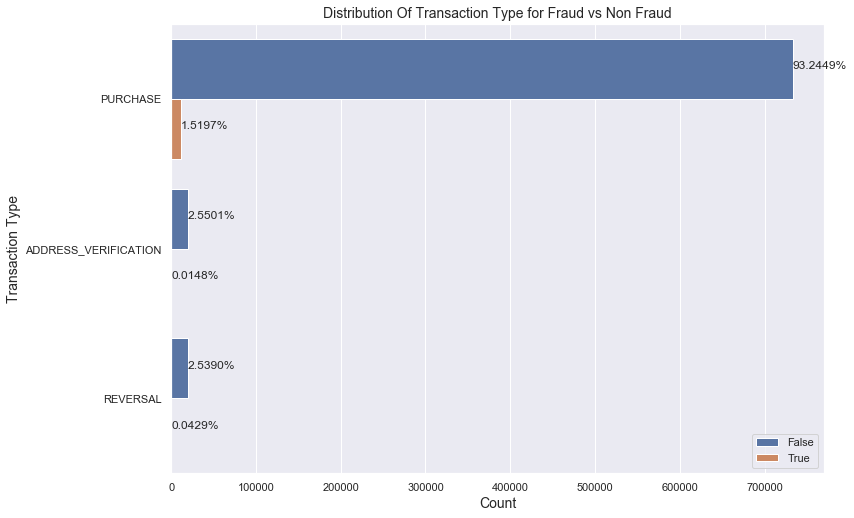

In [22]:
count_plot_separate (Data_Duplicates, y = "transactionType", x="isFraud")

In [43]:
# select the labels
cols = ["Address_Verification", "Normal","Reversal","MultiSwipe_Not_Normal"]


def boxplot_all (data,x,y):
    '''
    This function plot the 5 number summary and outliers, box plot, of a numerical variable,y, vs a categorical 
    variable,x.
    '''
    fig, ax = plt.subplots(figsize=(20,10));
    bplot = sns.boxplot(x=x,y=y,data=data, order=cols)
    medians = data.groupby([x])[y].median().sort_values(ascending=True)
    vertical_offset = data[y].median() * 0.9 # offset from median for display

    for xtick in bplot.get_xticks():
        bplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size = 14,color='black',weight='semibold')

    ax.set_title("Transaction Amount Meadian For Different Transaction Types",fontsize=14);
    ax.set_xlabel(x, fontsize=14);
    ax.set_ylabel(y, fontsize=14);

In [44]:
## barchart revenue vs property type. This plot also shows outliers for each property 
def boxplot_seperate (data,x,y):
    '''
    This function plot the 5 number summary and outliers, box plot, of a numerical variable,y, vs a categorical 
    variable,x, seperated by another class.
    '''
    fig, ax = plt.subplots(figsize=(20,10));
    bplot = sns.boxplot(x=x,y=y,data=data,hue='isFraud', order=cols)
    
    ax.set_title("Transaction Amount Meadian For Different Transaction Types",fontsize=14);
    ax.set_xlabel(x, fontsize=14);
    ax.set_ylabel(y, fontsize=14);

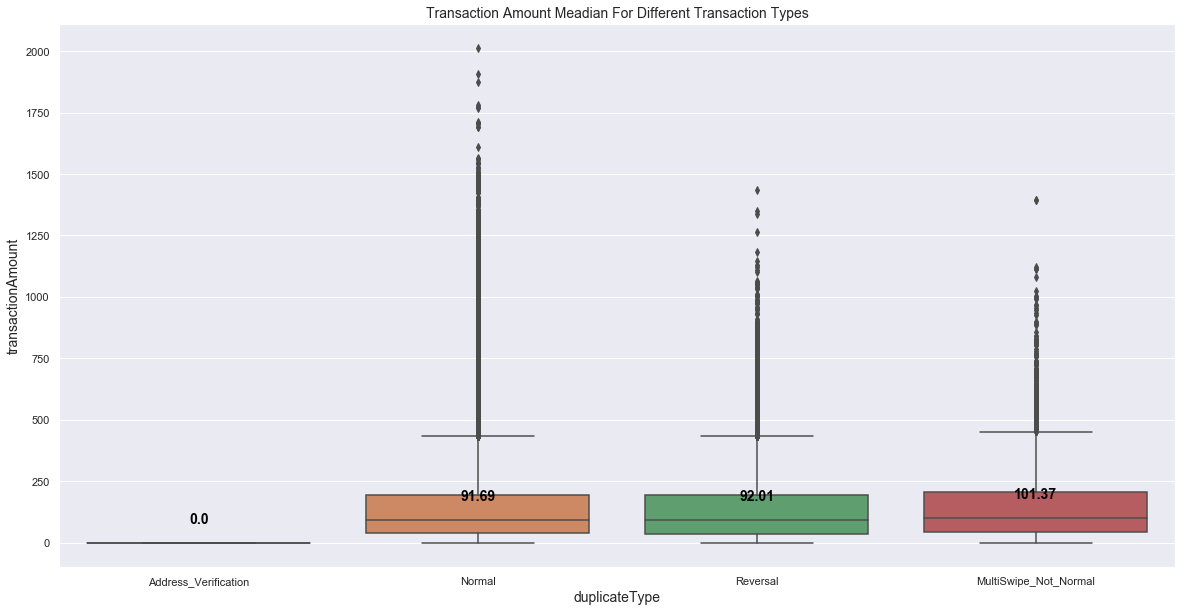

In [26]:
# on average more money spend on multi swipe than any others.
boxplot_all (Data_Duplicates,x='duplicateType',y='transactionAmount')

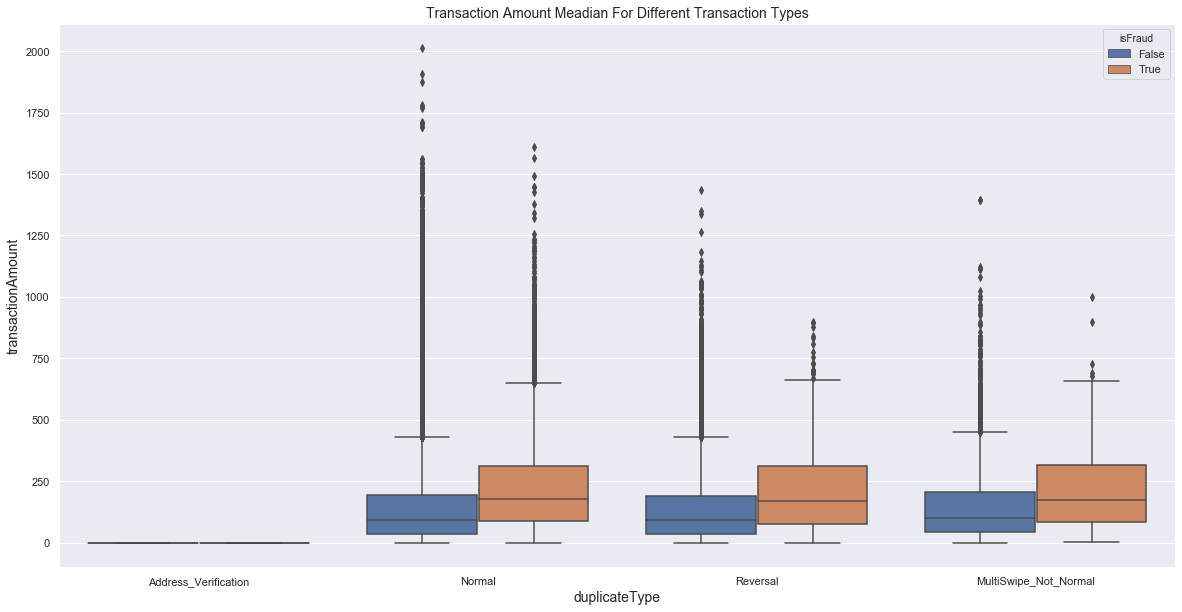

In [27]:
#the median transaction amount for fraudulent and genuine transactions was slightly different. 
boxplot_seperate (Data_Duplicates,x='duplicateType',y='transactionAmount')

In [28]:
## compare different types of occurrence in Fraud transactions together 
## compare different types of occurrence in Non-Fraud transactions together 
Data_Duplicates.groupby(['isFraud']).transactionType.value_counts(normalize=True).mul(100)

isFraud  transactionType     
False    PURCHASE                94.824652
         ADDRESS_VERIFICATION     2.593300
         REVERSAL                 2.582049
True     PURCHASE                96.347658
         REVERSAL                 2.717085
         ADDRESS_VERIFICATION     0.935258
Name: transactionType, dtype: float64

In [29]:
Data_Duplicates.groupby(['isFraud']).transactionType.value_counts()

isFraud  transactionType     
False    PURCHASE                733243
         ADDRESS_VERIFICATION     20053
         REVERSAL                 19966
True     PURCHASE                 11950
         REVERSAL                   337
         ADDRESS_VERIFICATION       116
Name: transactionType, dtype: int64

I was also curious to explore more about the amount of money spent differently for all merchant's category identified as Fraud. I noticed in fraudulent transactions, average money that swiped multiple times in subscriptions was the highest compared to other categories, 392$. Also, on average 304$ captured in a reversed transaction in the hotel industry that was fraudulent.

Total number of reversal transactions is 20303.
Total dollar amount of reversal transactions is 2821792.5.
Total dollar amount for reversal transactions for both Fraud and non Fraud is          transactionAmount
isFraud                   
False            2744980.7
True               76811.8.


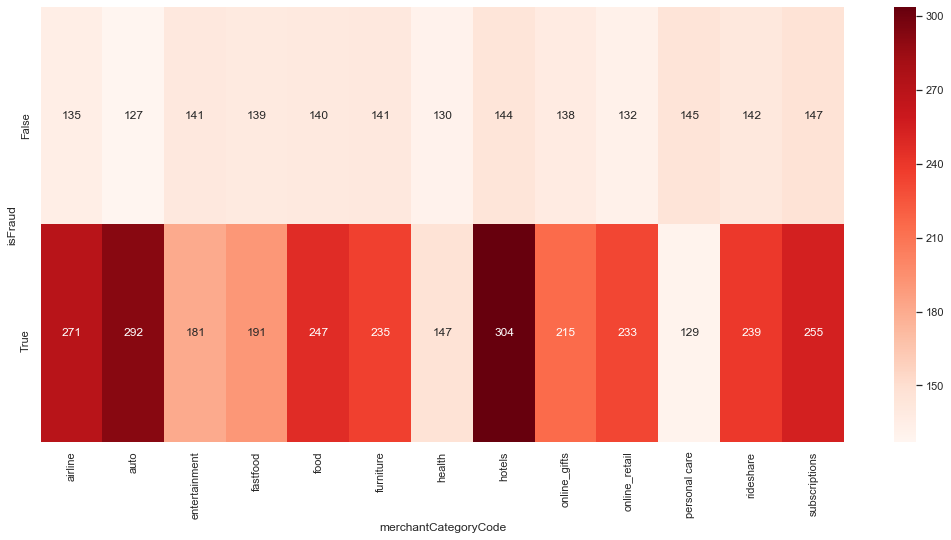

In [30]:
## total number of transactions and total dollar amount for reversed transactions
data_reversed = Data_Duplicates[Data_Duplicates.duplicateType == 'Reversal']

print('Total number of reversal transactions is {}.'.
      format(data_reversed.shape[0]))
print('Total dollar amount of reversal transactions is {}.'.
      format(data_reversed.transactionAmount.sum()))
print('Total dollar amount for reversal transactions for both Fraud and non Fraud is {}.'.
      format(data_reversed .groupby(['isFraud']).agg({'transactionAmount': 'sum'})))

## plot average dollar amount for reversed transactions
fig, ax = plt.subplots(figsize=(18,8))
sea_heat = sns.heatmap(data_reversed.groupby(['isFraud','merchantCategoryCode']).transactionAmount.mean().unstack(),cmap="Reds",annot=True, fmt=".0f",ax=ax);
fig = sea_heat.get_figure()

Total number of non normal multiswipe transactions is 7471.
Total dollar amount of non normal multiswipe transactions is 1105507.04.
Total dollar amount of of non normal multiswipe transactions for both Fraud and non Fraud is          transactionAmount
isFraud                   
False           1076705.43
True              28801.61.


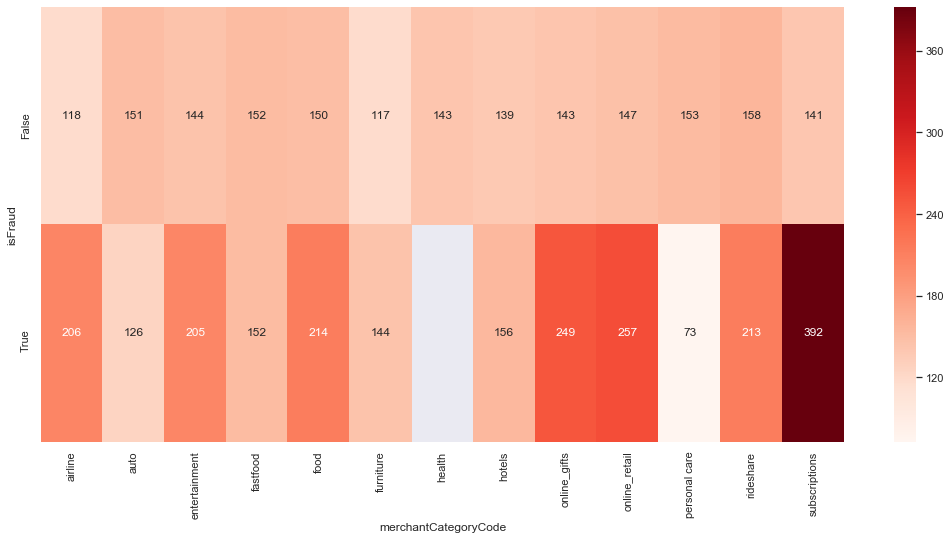

In [31]:
## total number of transactions and total dollar amount for non normal multiswipe transactions
data_multiswipe = Data_Duplicates[Data_Duplicates.duplicateType == 'MultiSwipe_Not_Normal']
print('Total number of non normal multiswipe transactions is {}.'.
      format(data_multiswipe.shape[0]))
print('Total dollar amount of non normal multiswipe transactions is {}.'.
      format(data_multiswipe.transactionAmount.sum()))
print('Total dollar amount of of non normal multiswipe transactions for both Fraud and non Fraud is {}.'.
      format(data_multiswipe.groupby(['isFraud']).agg({'transactionAmount': 'sum'})))
## plot average dollar amount for non normal multiswipe transactions
fig, ax = plt.subplots(figsize=(18,8))
sea_heat = sns.heatmap(data_multiswipe.groupby(['isFraud','merchantCategoryCode']).transactionAmount.mean().unstack(),cmap="Reds",annot=True, fmt=".0f",ax=ax);
fig = sea_heat.get_figure()

In [34]:
total_transactions = Data_Duplicates.groupby(['duplicateType','isFraud'])['transactionAmount'].sum()
count_transactions = Data_Duplicates.groupby(['duplicateType','isFraud'])['transactionAmount'].count()
mean_transactions = Data_Duplicates.groupby(['duplicateType','isFraud'])['transactionAmount'].mean()
print('Total Transactions Amount {}.'.
      format(total_transactions))
print('---' * 60)
print('Average Transactions Amount {}.'.
      format(mean_transactions))

Total Transactions Amount duplicateType          isFraud
Address_Verification   False      0.000000e+00
                       True       0.000000e+00
MultiSwipe_Not_Normal  False      1.076705e+06
                       True       2.880161e+04
Normal                 False      1.009981e+08
                       True       2.686726e+06
Reversal               False      2.744981e+06
                       True       7.681180e+04
Name: transactionAmount, dtype: float64.
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Average Transactions Amount duplicateType          isFraud
Address_Verification   False        0.000000
                       True         0.000000
MultiSwipe_Not_Normal  False      146.670131
                       True       221.550846
Normal                 False      139.134583
                       True       227.303389
Reversal        

Step 4) Predictive Modeling 

To estimate if a transaction is a fraud or not, based on the available data, I created new features that are as following:

'CustomerType': I classified a customer who opened the account before 2013 as "Old" customers; otherwise, as "New". I think the longer a customer is using the credit card makes them be more familiar with the specific regulations and helps them to protect their account even more. That is the reason I developed this binary variable. But, if I had more time I would like to consider this as a numerical variable representing the number of years instead of if the account is old or not. 

'EnterWrongCVV': A binary variable that set as "True" if the entered CVV is the same as actual CVV. 

'DaysToExpire': Number of days card about to expire which is the number of days between the transaction date and card expiration date. I found in interesting to investigate more if the fraud happened at the early or late stages of a card expires.  If I had more time I would definitely consider the number of months as well with more knowledge in the bank industry. 

'DaysChangedAddress': Number of days address changed. Which is the number of days between last time the address updated and transaction.

'MonthTransaction': It represents the month of the transaction. I assumed during holiday seasons there might be a higher chance of Fraud ones because of higher number of transactions.

'MoneySpent': A value between 0 and 1 that shows the percentage of the current balance compared to the credit limit. 

'purchase_money_diff': The lag of money a card being charged. 

'purchase_time_diff': The lag of time each card being used for purchases. The reason I added lag money and lag time were because, I assumed if a card had been stolen, probably in a short time, it would be charged by a small amount, and following with large amounts. It would be charged by smaller amounts to be sure the card is working properly. Another reason I added these two features was the skewed transaction amount distribution. It is obvious that the transaction amount is highly correlated with fraudulent transactions. But, I have to be careful how far do I want to set the threshold for removing outliers. I might lose some information about big transactions being Fraud due to a lack of data in this class. So, money_diff would be a good replacement. But I considered both in my predictive analysis and my model performed better with "money_diff" than "transactionAmount".

I also trained my models with and without duplicate types. Duplicate and transaction types have zero-variance due to low frequencies in some classes and might result in lower prediction performance. So, I limited my objective to classify fraud in normal transactions.

All the discussed variables are generated in the "add_features" function. I saved the data with added features as "Data_New_Features" with 32 columns. 

In [36]:
def add_features (data):
    '''
    This function prepares the data for prediction analysis and adds new features listed above.  
    
    '''
    # change the accountOpenDate format to date 
    data['accountOpenDate'] =  pd.to_datetime(data['accountOpenDate'], format='%Y-%m-%d')
    # change the dateOfLastAddressChange format to date 
    data['dateOfLastAddressChange'] =  pd.to_datetime(data['dateOfLastAddressChange'], format='%Y-%m-%d')
    # change the transactionDateTime and currentExpDate format to date 
    data['transactionDateTime'] =  pd.to_datetime(data['transactionDateTime'], format='%Y-%m-%d %H:%M:%S')
    data['transactionDateTime'] =  pd.to_datetime(data['transactionDateTime']).dt.date
    data['transactionDateTime'] =  pd.to_datetime(data['transactionDateTime'], format='%Y-%m-%d')
    data['currentExpDate'] = data['currentExpDate'].apply( lambda x: datetime.strptime(x, '%m/%Y')\
                                                              .replace(day=1)\
                                                              .strftime('%Y-%m-%d'))
    data['currentExpDate'] =  pd.to_datetime(data['currentExpDate'], format='%Y-%m-%d')
    # add CustomerType variable 
    data.loc[(data['accountOpenDate'] <= '2013-01-01'), 'CustomerType'] = 'Old'
    data.loc[(data['accountOpenDate'] > '2013-01-01'), 'CustomerType'] = 'New'
    # add CEnterWrongCVV variable 
    data.loc[(data['cardCVV'] == data['enteredCVV']), 'EnterWrongCVV'] = False
    data.loc[(data['cardCVV'] != data['enteredCVV']), 'EnterWrongCVV'] = True
    # add DaysToExpire variable 
    data['DaysToExpire'] = abs((data['transactionDateTime'] - data['currentExpDate']).astype('timedelta64[D]'))
    # add DaysChangedAddress variable 
    data['DaysChangedAddress'] = abs((data['transactionDateTime'] - data['dateOfLastAddressChange']).astype('timedelta64[D]'))
    # add month of the transaction  
    data['MonthTransaction'] = pd.DatetimeIndex(data['transactionDateTime']).month
    #data['YearTransaction'] = pd.DatetimeIndex(data['transactionDateTime']).year
    # add day of the transaction
    data['weekday'] = data['transactionDateTime'].dt.weekday_name
    # add the percentage money spent compared to the credit limit
    data['MoneySpent'] = data['currentBalance'] *100 / data['creditLimit']
    
    grouped = data.groupby(['accountNumber','cardCVV','cardLast4Digits', 'transactionType'], as_index=False)

    timediff = lambda x: x['transactionDateTime'].diff()
    moneydiff = lambda x: x['transactionAmount'].diff()
    # add two variables time_diff and money_diff that represent the time period and money charged for each card 

    data.loc[data['transactionType'] == 'PURCHASE', 'purchase_time_diff'] = grouped.apply(timediff).reset_index(0, drop=True)
    data.loc[data['transactionType'] == 'PURCHASE', 'purchase_money_diff'] = grouped.apply(moneydiff).reset_index(0, drop=True)
    # replace the Na values with zero 
    data['purchase_money_diff'] = data['purchase_money_diff'].fillna(0)
    
    ## just select the purchase records
    data = data.loc[data['duplicateType'] == 'Normal']
    data = data.drop(['duplicateType','transactionType'], axis=1)
    
    return(data)

In [37]:
Data_New_Features = add_features (Data_Duplicates)

In [38]:
print('Number Of records and features {}.'.format(Data_New_Features.shape))

Number Of records and features (737722, 32).


In [46]:
Data_New_Features.dtypes

accountNumber                         int64
accountOpenDate              datetime64[ns]
acqCountry                           object
availableMoney                      float64
cardCVV                               int64
cardLast4Digits                       int64
cardPresent                            bool
creditLimit                           int64
currentBalance                      float64
currentExpDate               datetime64[ns]
customerId                            int64
dateOfLastAddressChange      datetime64[ns]
enteredCVV                            int64
expirationDateKeyInMatch               bool
isFraud                                bool
merchantCategoryCode                 object
merchantCountryCode                  object
merchantName                         object
posConditionCode                     object
posEntryMode                         object
transactionAmount                   float64
transactionDateTime          datetime64[ns]
time_diff                   time

Step 4_1) Data visualization and exploration for predictive purposes 

The following box plot shows, the lag of money is almost normally distributed in Fraud and Non-Fraud transactions( with some outliers that need to be taken care of). But, Fraud ones have a higher median of around 63$. On average, the lag of money for fraud transactions within less than 1-hour was about 77$. 

The correlation and covariance matrix of numerical variables like 'transactionAmount', 'DaysChangedAddress' ,'DaysToExpire', 'MoneySpent', 'currentBalance', 'creditLimit', 'availableMoney', and 'purchase_money_diff' shows that "money_diff" is highly correlated with transactional amount that was expected. Money Spent is almost correlated with the current balance. To reduce multicollinearity, I use the current balance in my rest of the analysis since it has already existed in the data.

Also, the current balance and available money are highly correlated with the credit limit, not starange! I didn't like to exclude the credit limit from my predictive analysis, so I decided to have it as a categorical variable to remove the numerical distance and the correlation between these data points.  

The box plots show, in some numerical variables there is not a considerable difference between 5 number summary of fraud and non-fraud. For example, "DaysToExpire" and "DaysChangedAddress".

The distribution plot of numerical variables and their comparison with normal shows, number of days card about to expire and lag of money are normally distributed. The rest are skewed to the right. 

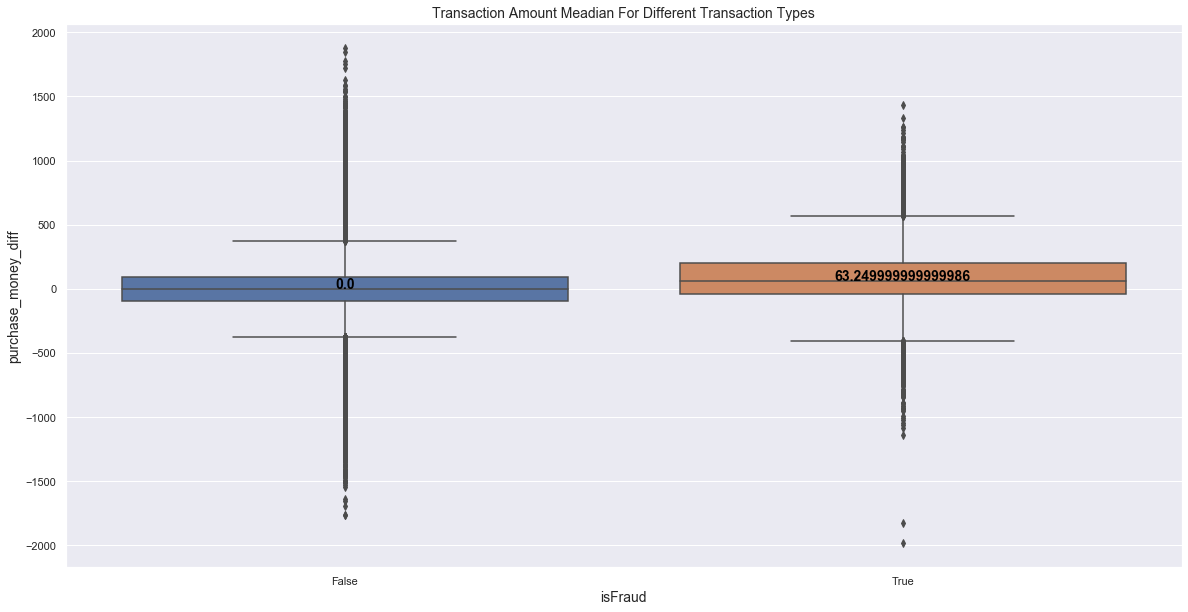

In [45]:
# box plot of money lag between Fraud and Non Fraud transaction 
cols = [False,True]
boxplot_all (Data_New_Features,x='isFraud',y='purchase_money_diff')

In [42]:
# lets see how the transcations money distributed for transactions within less than 1 hour
Data_LaggedMoney_OneHour = Data_New_Features.loc[Data_New_Features['purchase_time_diff'] < '0 days 01:00:00.000000000']

Stat_LaggedMoney_OneHour = Data_LaggedMoney_OneHour.groupby(['isFraud'])['purchase_money_diff'].describe()
print('Distribution of Lag Transactions Amount happening Less Than 1 hour')
Stat_LaggedMoney_OneHour
#On average, the lag of money for fraud transactions within less than 1-hour was about 77$. 

Distribution of Lag Transactions Amount happening Less Than 1 hour


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,313262.0,-1.418124,210.805179,-1691.05,-103.010,-0.83,100.8875,1626.36
True,5663.0,77.413514,242.102814,-1826.83,-46.745,66.58,201.8700,1431.45


In [43]:
# lets see how the transcations money distributed for all transcations
Stat_LaggedMoney = Data_New_Features.groupby(['isFraud'])['purchase_money_diff'].describe()
print('Distribution of Lag Transactions Amount')
Stat_LaggedMoney
#On average, the lag of money for fraud transactions within less than 1-hour was about 80$. 

Distribution of Lag Transactions Amount


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
False,725902.0,-1.608100,205.671897,-1767.14,-96.07,0.00,92.9600,1874.37
True,11820.0,80.554581,241.879009,-1979.05,-42.65,63.25,200.6275,1431.45


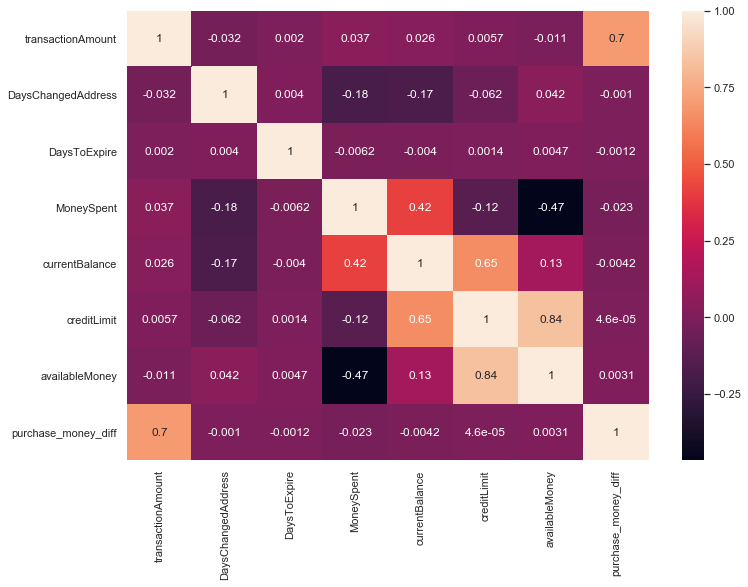

In [44]:
# correlation matrix of numerical variables
sns.heatmap(
    Data_New_Features[['transactionAmount','DaysChangedAddress','DaysToExpire','MoneySpent','currentBalance','creditLimit',
            'availableMoney','purchase_money_diff']].corr(),annot=True)

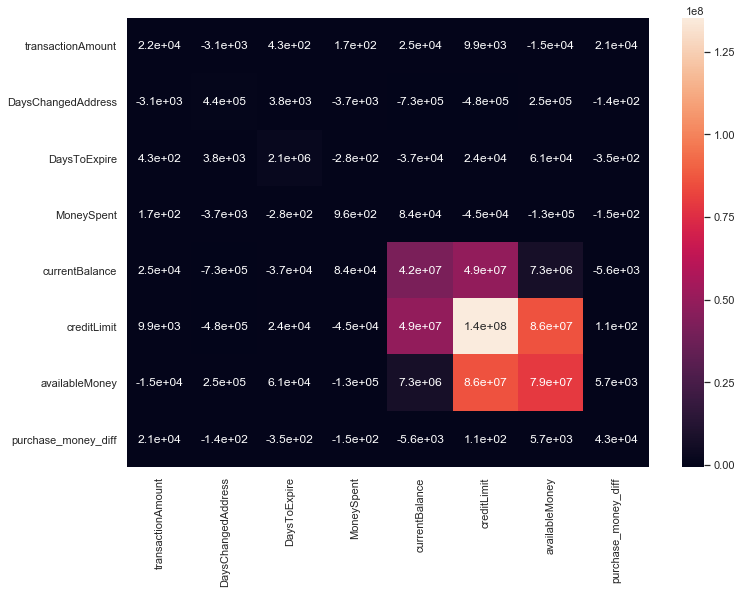

In [45]:
# covariance matrix of numerical variables
sns.heatmap(Data_New_Features[['transactionAmount','DaysChangedAddress','DaysToExpire','MoneySpent','currentBalance','creditLimit',
            'availableMoney','purchase_money_diff']].cov(), annot=True)

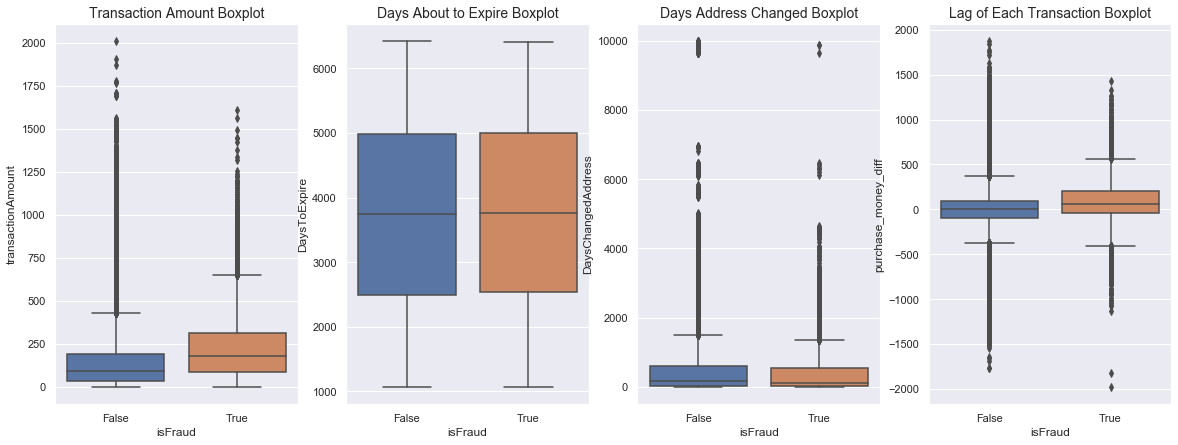

In [46]:
## Box plot all numerical variables  
f, axes = plt.subplots(1,4, figsize=(20,7))

sns.boxplot(x="isFraud", y="transactionAmount", data=Data_New_Features, ax=axes[0])
axes[0].set_title('Transaction Amount Boxplot',fontsize=14)

sns.boxplot(x="isFraud", y="DaysToExpire", data=Data_New_Features, ax=axes[1])
axes[1].set_title('Days About to Expire Boxplot', fontsize=14)


sns.boxplot(x="isFraud", y="DaysChangedAddress", data=Data_New_Features, ax=axes[2])
axes[2].set_title('Days Address Changed Boxplot', fontsize=14)

sns.boxplot(x="isFraud", y="purchase_money_diff", data=Data_New_Features, ax=axes[3])
axes[3].set_title('Lag of Each Transaction Boxplot', fontsize=14)

plt.show()
# The box plots show, in some numerical variables there is not a considerable difference between 5 
# number summary of fraud and non-fraud. For example, "DaysToExpire" and "DaysChangedAddress" .

Text(0.5, 1.0, 'Available Money Boxplot')

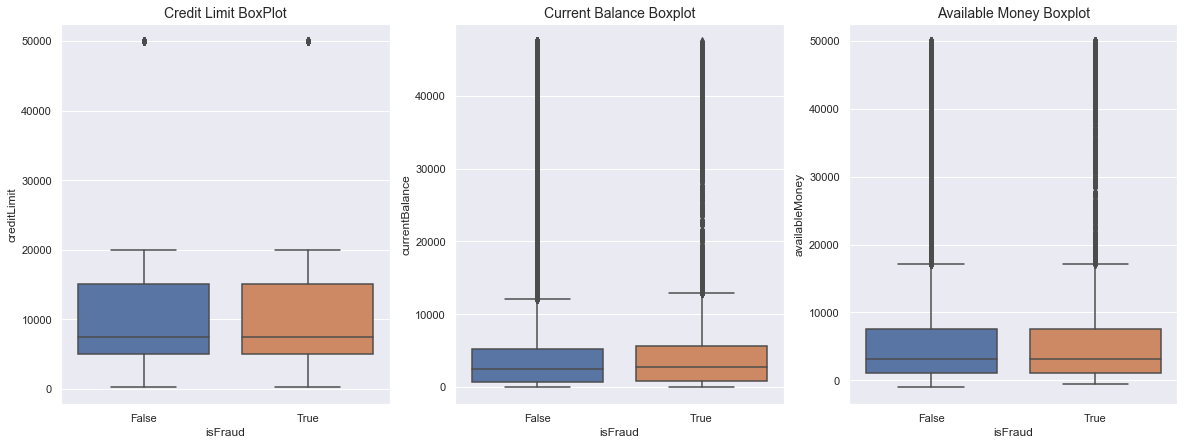

In [47]:
f, axes = plt.subplots(1,3, figsize=(20,7))

sns.boxplot(x="isFraud", y="creditLimit", data=Data_New_Features, ax=axes[0])
axes[0].set_title('Credit Limit BoxPlot', fontsize=14)

sns.boxplot(x="isFraud", y="currentBalance", data=Data_New_Features, ax=axes[1])
axes[1].set_title('Current Balance Boxplot', fontsize=14)

sns.boxplot(x="isFraud", y="availableMoney", data=Data_New_Features, ax=axes[2])
axes[2].set_title('Available Money Boxplot', fontsize=14)


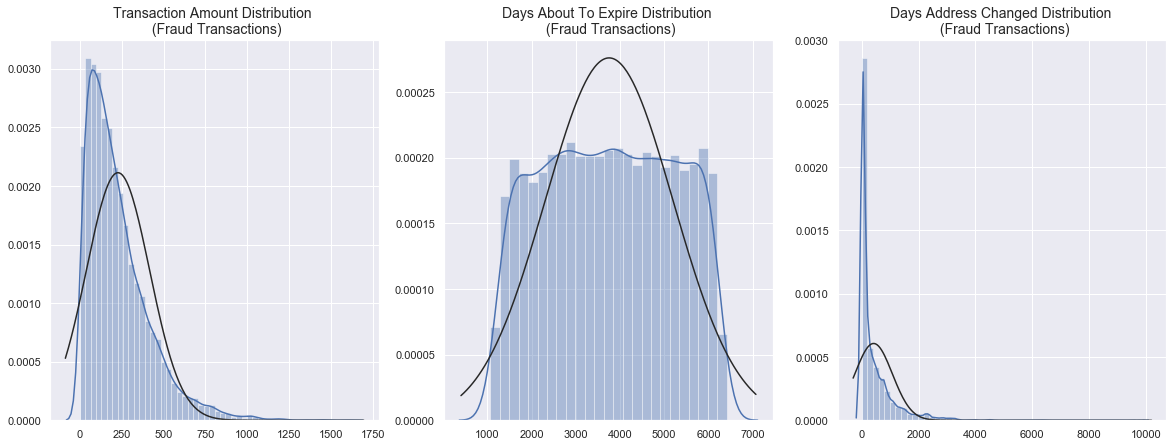

In [48]:
# numerical variables distribution and how far away they are from the normal distribution 
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20, 7))

transactionAmount_fraud_dist = Data_New_Features["transactionAmount"].loc[Data_New_Features['isFraud'] == 1].values
sns.distplot(transactionAmount_fraud_dist,ax=ax1, fit=norm)
ax1.set_title('Transaction Amount Distribution \n (Fraud Transactions)', fontsize=14)

daystoexpire_dist = Data_New_Features["DaysToExpire"].loc[Data_New_Features['isFraud'] == 1].values
sns.distplot(daystoexpire_dist,ax=ax2, fit=norm)
ax2.set_title('Days About To Expire Distribution \n (Fraud Transactions)', fontsize=14)


dayschangeaddress_fraud_dist = Data_New_Features["DaysChangedAddress"].loc[Data_New_Features['isFraud'] == 1].values
sns.distplot(dayschangeaddress_fraud_dist,ax=ax3, fit=norm)
ax3.set_title('Days Address Changed Distribution \n (Fraud Transactions)', fontsize=14)


plt.show()

Text(0.5, 1.0, 'Money Lag Distribution \n (Fraud Transactions)')

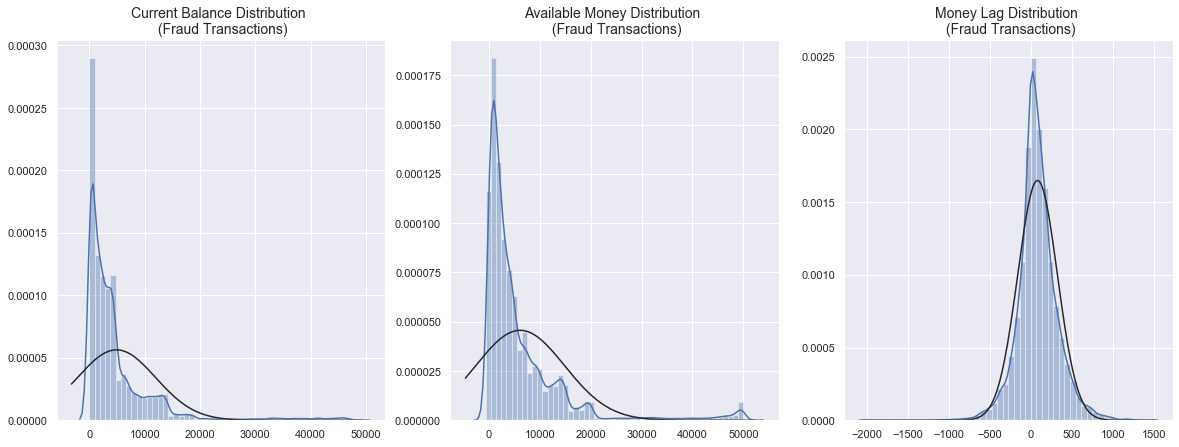

In [49]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20, 7))

currentbalance_fraud_dist = Data_New_Features["currentBalance"].loc[Data_New_Features['isFraud'] == 1].values
sns.distplot(currentbalance_fraud_dist,ax=ax1, fit=norm)
ax1.set_title('Current Balance Distribution \n (Fraud Transactions)', fontsize=14)

availablemoney_fraud_dist = Data_New_Features["availableMoney"].loc[Data_New_Features['isFraud'] == 1].values
sns.distplot(availablemoney_fraud_dist,ax=ax2, fit=norm)
ax2.set_title('Available Money Distribution \n (Fraud Transactions)', fontsize=14)

money_lag_fraud_dist = Data_New_Features["purchase_money_diff"].loc[Data_New_Features['isFraud'] == 1].values
sns.distplot(money_lag_fraud_dist,ax=ax3, fit=norm)
ax3.set_title('Money Lag Distribution \n (Fraud Transactions)', fontsize=14)

At this step, I will first scale the 'transactionAmount', 'availableMoney', 'currentBalance', and 'purchase_money_diff' columns in a smaller and same range. I used RobustScaler since it is less prone to outliers. 

In [47]:
# Scale the numeric variables since most of them are skewed
# I used RobustScaler because it is less prone to outliers
rob_scaler = RobustScaler()

Data_New_Features['scaled_amount'] = rob_scaler.fit_transform(Data_New_Features['transactionAmount'].values.reshape(-1,1))
Data_New_Features['scaled_avilablemoney'] = rob_scaler.fit_transform(Data_New_Features['availableMoney'].values.reshape(-1,1))
Data_New_Features['scaled_currentbalance'] = rob_scaler.fit_transform(Data_New_Features['currentBalance'].values.reshape(-1,1))
Data_New_Features['scaled_purchase_money_diff'] = rob_scaler.fit_transform(Data_New_Features['purchase_money_diff'].values.reshape(-1,1))
# After scaling, I removed the actual columns from the data set. 
Data_New_Features.drop(['transactionAmount','availableMoney', 'currentBalance','purchase_money_diff'], axis=1, inplace=True)

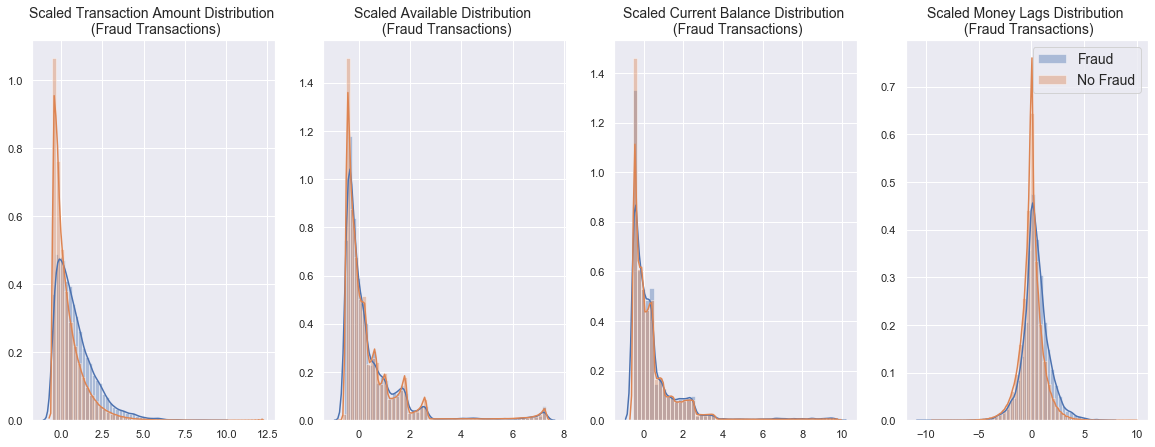

In [48]:
# now lets see how the distribution changed after scaling for both Fraud and Non Fraud 
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20, 7))

transactionAmount_fraud_dist = Data_New_Features["scaled_amount"].loc[Data_New_Features['isFraud'] == 1].values
transactionAmount_nonfraud_dist = Data_New_Features["scaled_amount"].loc[Data_New_Features['isFraud'] == 0].values
sns.distplot(transactionAmount_fraud_dist,ax=ax1,label='Fraud')
sns.distplot(transactionAmount_nonfraud_dist,ax=ax1,label='No Fraud')
ax1.set_title('Scaled Transaction Amount Distribution \n (Fraud Transactions)', fontsize=14)

daystoexpire_fraud_dist = Data_New_Features["scaled_avilablemoney"].loc[Data_New_Features['isFraud'] == 1].values
daystoexpire_nonfraud_dist = Data_New_Features["scaled_avilablemoney"].loc[Data_New_Features['isFraud'] == 0].values
sns.distplot(daystoexpire_fraud_dist,ax=ax2,label='Fraud')
sns.distplot(daystoexpire_nonfraud_dist,ax=ax2, label='No Fraud')
ax2.set_title('Scaled Available Distribution \n (Fraud Transactions)', fontsize=14)


dayschangeaddress_fraud_dist = Data_New_Features["scaled_currentbalance"].loc[Data_New_Features['isFraud'] == 1].values
dayschangeaddress_nonfraud_dist = Data_New_Features["scaled_currentbalance"].loc[Data_New_Features['isFraud'] == 0].values
sns.distplot(dayschangeaddress_fraud_dist,ax=ax3, label='Fraud')
sns.distplot(dayschangeaddress_nonfraud_dist,ax=ax3, label='No Fraud')
ax3.set_title('Scaled Current Balance Distribution \n (Fraud Transactions)', fontsize=14)

purchase_money_diff_fraud_dist = Data_New_Features["scaled_purchase_money_diff"].loc[Data_New_Features['isFraud'] == 1].values
purchase_money_diff_nonfraud_dist = Data_New_Features["scaled_purchase_money_diff"].loc[Data_New_Features['isFraud'] == 0].values
sns.distplot(purchase_money_diff_fraud_dist ,ax=ax4, label='Fraud')
sns.distplot(purchase_money_diff_nonfraud_dist,ax=ax4, label='No Fraud')
ax4.set_title('Scaled Money Lags Distribution \n (Fraud Transactions)', fontsize=14)

plt.legend(prop={'size': 14})

In [49]:
print('Summary Of Scaled Transaction Amount')
Data_New_Features["scaled_amount"].loc[Data_New_Features['isFraud'] == 1].describe()

Summary Of Scaled Transaction Amount


count    11820.000000
mean         0.856848
std          1.192764
min         -0.579263
25%         -0.018449
50%          0.552695
75%          1.399318
max          9.582738
Name: scaled_amount, dtype: float64

In [50]:
print('Lag Of Transactions Amount for Fraud ones /(Scaled) :')
display(Data_New_Features["scaled_purchase_money_diff"].loc[Data_New_Features['isFraud'] == 1].describe())
print('---' * 60)
print('Lag Of Transactions Amount for Non Fraud ones / (Scaled) :')
display(Data_New_Features["scaled_purchase_money_diff"].loc[Data_New_Features['isFraud'] == 0].describe())

Lag Of Transactions Amount for Fraud ones /(Scaled) :


count    11820.000000
mean         0.423637
std          1.272043
min        -10.407836
25%         -0.224297
50%          0.332632
75%          1.055101
max          7.528004
Name: scaled_purchase_money_diff, dtype: float64

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Lag Of Transactions Amount for Non Fraud ones / (Scaled) :


count    725902.000000
mean         -0.008457
std           1.081630
min          -9.293400
25%          -0.505233
50%           0.000000
75%           0.488877
max           9.857323
Name: scaled_purchase_money_diff, dtype: float64

Step 4-2) Outlier Detection

In this section, I analyzed the extreme outliers from features that have a high correlation with fraud. This will have a positive impact on the accuracy of the predictive model. But, using the appropriate threshold requires a deeper understanding of data and knowing why outliers occur to reduce the chance of information loss. Specifically, in an imbalanced dataset like this. For this reason, I trained my model for both scenarios with and without outliers. 

First, I removed the extreme ones I selected my threshold based on the 25 and 75 percentile range. And removed the records with 2,3, and 4 standard deviations away from the mean for Non-Fraud ones since I didn't want to lose data for low-frequency occurrences. 

You can change the threshold amount and see how many records will be removed from the dataset using "remove_outliers" function. 

I didn't remove the scaled money lags outliers since it is already scaled between -5 to 5. Second, I decided to keep the outliers even if it lowers the model accuracy. 

In [102]:
# make a copy of data for outlier analysis to compare the result of with and without outlier removals 
df = Data_New_Features.copy() # exclude outliers

In [121]:
def remove_outliers(data,x,cut_off):
    '''
    This function detects the number of outliers for x column in the data dataframe. 
    
    The cut_off can be changed to any integer.since I didn't want to lose data for low-frequency occurrences
    
    I am interested in detecting outliers from Non-Fraud transactions. 
     
    '''
    money_nofraud = data[x].loc[data['isFraud'] == 0].values
    q25, q75 = np.percentile(money_nofraud, 25), np.percentile(money_nofraud, 75)
    print('Quartile 25%: {} | Quartile 75%: {}'.format(q25, q75))
    interval = q75 - q25
    print('---' * 60)
    print('[75% - 25%] difference is : {}'.format(interval))

    ## outliers are the ones with 3 standard deviation away from mean
    
    amount_lower_cutoff, amount_upper_cutoff = data[x].loc[data['isFraud'] == 0].mean() -\
                cut_off * data[x].loc[data['isFraud'] == 0].std(),\
                data[x].loc[data['isFraud'] == 0].mean() + \
                cut_off * data[x].loc[data['isFraud'] == 0].std()
    print('---' * 60)
    print('Lower Amount is: {}'.format(amount_lower_cutoff))
    print('---' * 60)
    print('Upper Amount is: {}'.format(amount_upper_cutoff))
    print('---' * 60)
    outliers = [x for x in money_fraud  if x < amount_lower_cutoff or x > amount_upper_cutoff]
    print('Number of Outliers for Non_Fraud Cases: {}'.format(len(outliers)))
    

In [122]:
## Number of records for scaled_avilablemoney which are 3 standard devation away from mean
remove_outliers(data = df, x= 'scaled_avilablemoney',cut_off =3)

Quartile 25%: -0.32960400715987015 | Quartile 75%: 0.6703948247081714
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[75% - 25%] difference is : 0.9999988318680415
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Lower Amount is: -3.6773790309429377
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Upper Amount is: 4.63295792272308
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Outliers for Non_Fraud Cases: 23610


In [123]:
## Number of records for scaled_currentbalance which are 3 standard devation away from mean
remove_outliers(data = df, x= 'scaled_currentbalance',cut_off =3)

Quartile 25%: -0.3828564135039739 | Quartile 75%: 0.6165479480747296
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[75% - 25%] difference is : 0.9994043615787035
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Lower Amount is: -3.7658069384010644
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Upper Amount is: 4.66164995382635
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Outliers for Non_Fraud Cases: 16654


In [124]:
## Number of records for scaled_amount which are 3 standard devation away from mean
remove_outliers(data = df, x= 'scaled_amount',cut_off =3)

Quartile 25%: -0.34794970619826876 | Quartile 75%: 0.6414829089530548
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[75% - 25%] difference is : 0.9894326151513235
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Lower Amount is: -2.4820681411947962
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Upper Amount is: 3.0816079543213357
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Outliers for Non_Fraud Cases: 13798


In [68]:
# remove them from actual data
#df_removed_outlier = df_removed_outlier.drop(df_removed_outlier[(df_removed_outlier['scaled_amount'] > amount_upper_1) | (df_removed_outlier['scaled_amount'] < amount_lower_1)].index)
#df_removed_outlier = df_removed_outlier.drop(df_removed_outlier[(df_removed_outlier['scaled_currentbalance'] > amount_upper_2) | (df_removed_outlier['scaled_currentbalance'] < amount_lower_2)].index)
#df_removed_outlier = df_removed_outlier.drop(df_removed_outlier[(df_removed_outlier['scaled_avilablemoney'] > amount_upper_3) | (df_removed_outlier['scaled_avilablemoney'] < amount_lower_3)].index)

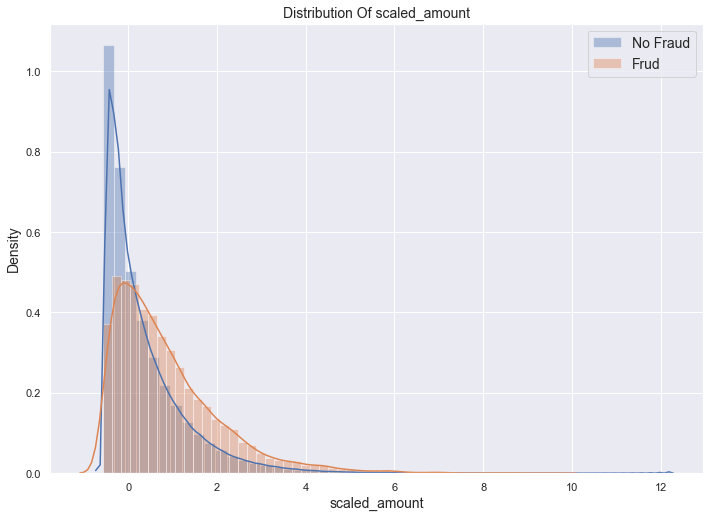

In [125]:
## distribution plot after removing outliers 
distribution_plot_separate (df_removed_outlier,x = "scaled_amount")

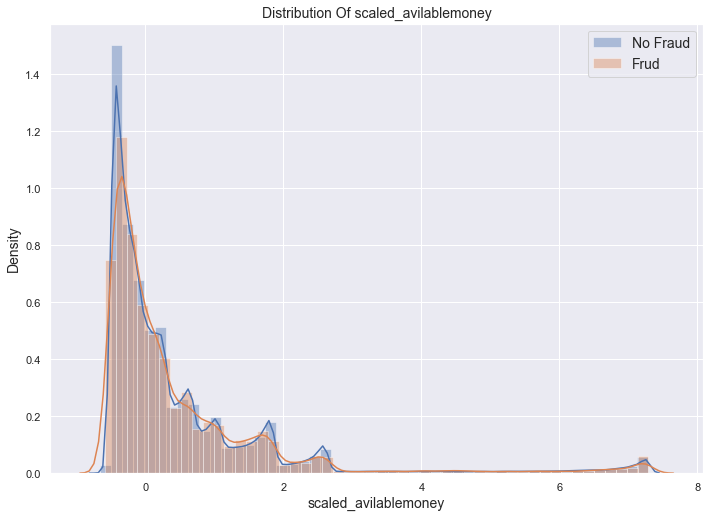

In [126]:
## distribution plot after removing outliers 
distribution_plot_separate (df_removed_outlier,x = "scaled_avilablemoney")

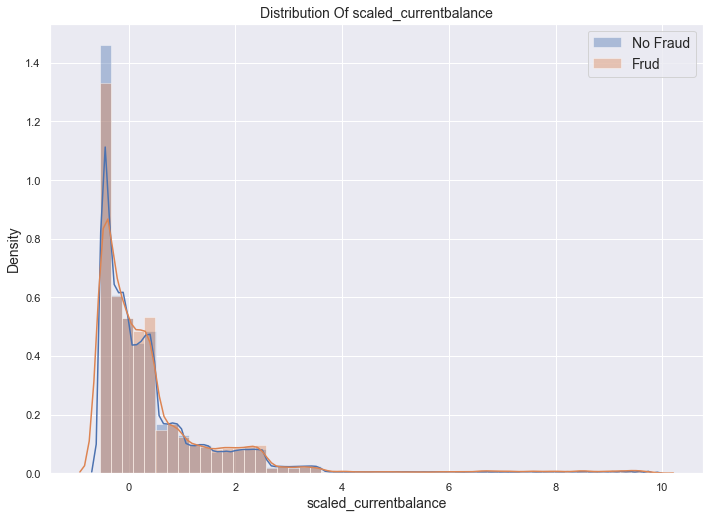

In [127]:
## distribution plot after removing outliers 
distribution_plot_separate (df_removed_outlier,x = "scaled_currentbalance")

In [71]:
# Acual data with outliers
df = Data_New_Features  

In [103]:
## make creditLimit and some other numerical variables to categorical, like 'posEntryMode'
df['MonthTransaction'] = df.MonthTransaction.astype(str)
df['creditLimit'] = df.creditLimit.astype(str)
df['posEntryMode'] = df.posEntryMode.astype(str)
df['posConditionCode'] = df.posConditionCode.astype(str)

In [104]:
# list of variables I want to include in my prediction analysis
columns = {'acqCountry','cardPresent','creditLimit','expirationDateKeyInMatch',"scaled_currentbalance","scaled_avilablemoney",
           'isFraud','merchantCategoryCode','merchantCountryCode','posConditionCode',
           'posEntryMode','scaled_purchase_money_diff','EnterWrongCVV','CustomerType','MonthTransaction','weekday'}

df_ready_modeling = df[columns]

In [105]:
# dealing with missing values to prepare data for predictive analysis
df_ready_modeling.isnull().sum()/len(Data)

isFraud                       0.000000
expirationDateKeyInMatch      0.000000
posConditionCode              0.000000
scaled_avilablemoney          0.000000
scaled_purchase_money_diff    0.000000
scaled_currentbalance         0.000000
merchantCountryCode           0.000874
weekday                       0.000000
merchantCategoryCode          0.000000
MonthTransaction              0.000000
EnterWrongCVV                 0.000000
creditLimit                   0.000000
cardPresent                   0.000000
acqCountry                    0.005457
posEntryMode                  0.000000
CustomerType                  0.000000
dtype: float64

In [106]:
# removing the records having NA values for acqCountry and merchantCountryCode
df_ready_modeling = df_ready_modeling.dropna()

Step 4-3) Re-Encode Categorical Features

For categorical data, I encoded the levels as dummy variables. Depending on the number of categories, performed one of the following:

1)For binary categoricals like "isFraud" and "expirationDateKeyInMatch", I changed the True levels to 1 and False level to 0.

2)For multi-level categoricals like 'creditLimit', 'merchantCountryCode',  and 'merchantCategoryCode', I chose to encode the values and create one column for each level having 0 and 1. In the end, removing the original categorical column, also removing columns that has all zero values. 

3)'posEntryMode', 'posConditionCode', and 'creditLimit' converted to categorical variables.


In [107]:
# encode binary variables that dont have missing values
# list of binary variables 
binary_vars = ['cardPresent','EnterWrongCVV','expirationDateKeyInMatch','CustomerType']
for var in binary_vars:
    df_ready_modeling [var] = np.where(df_ready_modeling [var] == "t" ,1 , 0)
    
# encode categorical variables with more than two levels and keep the missings as a new level to data
# list of categorical variables
categorical_vars = ['creditLimit', 'merchantCountryCode', 'merchantCategoryCode', 'posEntryMode',\
                      'acqCountry', 'MonthTransaction','weekday',\
                      'posConditionCode']
for var in categorical_vars:
     df_ready_modeling  = pd.concat([df_ready_modeling .drop(var, axis=1),\
                        pd.get_dummies(df_ready_modeling[var],\
                                       prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)

In [108]:
### remove columns that has all zero values 
df_ready_modeling = df_ready_modeling.loc[:, (df_ready_modeling != 0).any(axis=0)]

In [109]:
# number of rows and columns ready for modeling
df_ready_modeling.shape

(733428, 70)

In [110]:
# count of Fraud and Non Fraud occurance 
df_ready_modeling['isFraud'].value_counts()

False    721752
True      11676
Name: isFraud, dtype: int64

Step 4_4) Imbalanced Data

A I mentioned before, our target class is highly imbalanced. About 98% of the transactions are non-fraud and 2% are fraud. If I use this data as the base for predictive analysis, the result might have a lot of errors and the algorithms will probably overfit since it will assume that most transactions are not a fraud. So, I should be careful with the prediction at this step.

There are several ways to approach this classification problem considering data being imbalanced. One is to collect more data. Second is changing the performance metric. For example, accuracy is not a good metric and instead, Precision and Recall or their trade-off should be considered. Also, the AUC (area under the curve) and ROC curve are interesting to check, but it is not a good tool for assessing the models' performance in imbalanced data with many errors. Thirdly, over resampling from the minority class and undersampling from the majority class are two other ways of dealing with this kind of problem. 

I have trained Logistic Regression and Random Forest classifiers on the actual data to show the models are overfitting and accuracy is not a good proxy. 

I trained a benchmark RF model to find what percentage of variation in distinguishing transactions can be explained by the selected features. And find the important features. The result shows transaction weekdays and month, current balance, lag of money between each transaction and available money are recognized as important features by RF based on the purity these variables caused at each split.  

Distribution of the Classes
False    0.98408
True     0.01592
Name: isFraud, dtype: float64
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


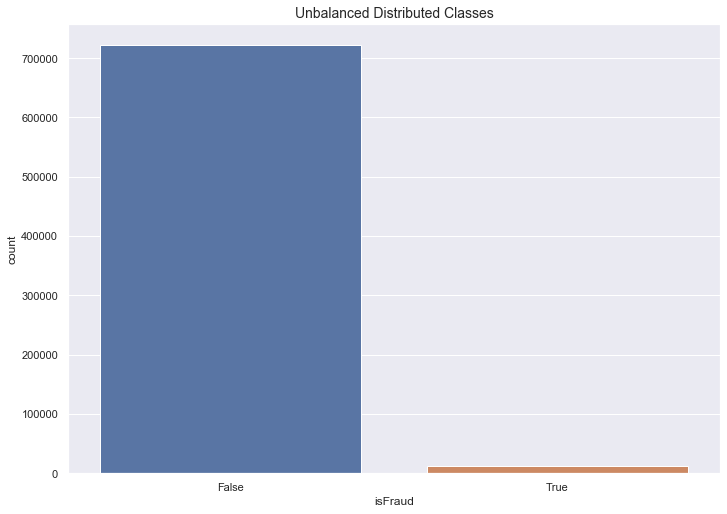

In [111]:
# The data is highly inbalanced.
print('Distribution of the Classes')
print(df_ready_modeling['isFraud'].value_counts()/len(df_ready_modeling))
print('---' * 60)

sns.countplot('isFraud', data=df_ready_modeling)
plt.title('Unbalanced Distributed Classes', fontsize=14)
plt.show()

Step 4-5) Split the data to train and test and Select appropriate Classifiers

In this section, I considered 80% of the data for training and saved 20% to evaluate the best model. 

Random Forest is a bagging technique that forcing each split to consider only a subset of predictors. It has fewer predictors and is more flexible. Because of this decorrelating process and giving all predictors a chance to contribute in prediction, it doesn't overfit easily. Overall, the reason I selected RF was that it can discover more complex dependencies regarding nonlinearity in the data compared to linear models. It also is faster than Gradient Boosted trees and Support Vector Classifiers. I trained SVC but it was running for hours while oversampling the data 5 times, so I had to interrupt it.  Also, since the number of predictors compared to records was less, SVC with kernels might cause overfitting and with linear kernel, it performs the same as Logistic Regression. So, I fitted Logistic Regression as well. 

I applied GridSearch and 5-fold cross-validation techniques to find the best hyperparameters for both algorithms. I used l1 and l2 regularization to penalize the loss function logistic regression. And selected different ranges of trees for Random Forest tuning. The 50 number of trees with bootstrapped data provided the most accurate model in the original dataset, not oversampled. 


In [112]:
# save the target variable in array y
X = df_ready_modeling.drop('isFraud', axis=1)
y = df_ready_modeling['isFraud']

# split the data to 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array ready for classification 
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [81]:
X_train.shape

(586742, 67)

In [113]:
## benchmark Random Forest with default parameters to find the important features 
rf = RandomForestClassifier(random_state = 12)
# train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

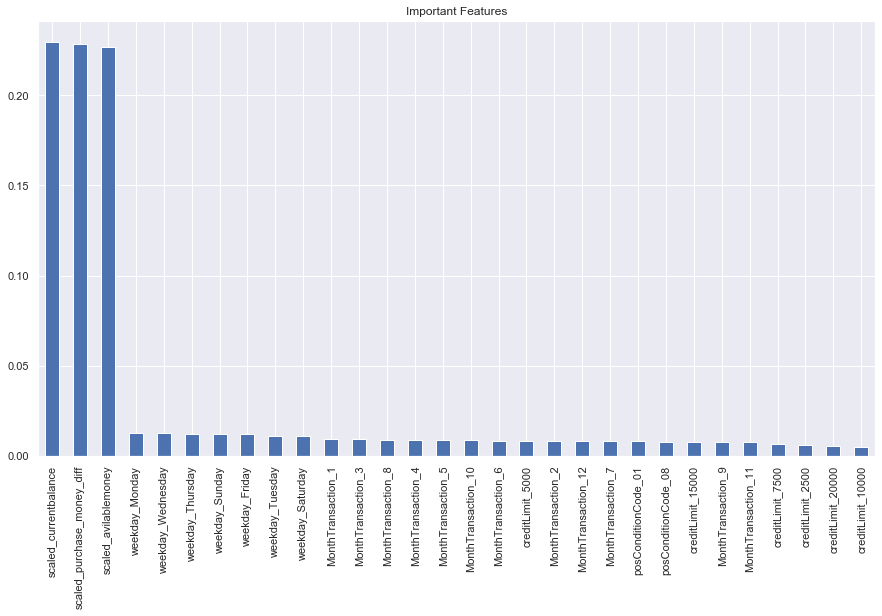

In [114]:
#### important variables as a bar chart for benchmark RF model
predictors=list(X_train)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False).head(30)
feat_imp.plot(kind='bar', title='Important Features', figsize=(15,8))
# plt.ylabel('Feature Importance Score')

In [115]:
# read the classifiers with a seed. using Logistic Regression and Random Forest
classifiers = {
    'LogisiticRegression': LogisticRegression(random_state = 12),
    'RandomForestClassifier': RandomForestClassifier(random_state = 12)
}

In [116]:
# Logestic regression and Random Foreset accuracy that overfit with no cross validation
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 4) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.41 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 98.37 % accuracy score


In [117]:
## Using GridSearchCV to find the best parameters
# I just used GridSearch on train set since the training time was slow and I am sure I have to use 
# resampling techniques techniques and retrain model one more time. 

# Logistic Regression Classifier best fity
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# Random Forest Classifier
rf_params = {'bootstrap': [True,False],  
             'max_features': ['auto', 'sqrt'],
              'n_estimators': [10, 20,30,40,50,60]}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_train, y_train)

# Random Forest estimator best fit
rf_clf = grid_rf.best_estimator_

In [118]:
#Random Forest best parameters 
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [120]:
#Logistic Regression best parameters 
log_reg

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
# train the best model on 5 fold cross validated sets 
log_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression with Cross Validation: ', round(log_score.mean() * 100, 4).astype(str) + '%')

rf_score = cross_val_score(rf_clf, X_train, y_train, cv=5)
print('Random Forest Classifier with Cross Validation', round(rf_score.mean() * 100, 4).astype(str) + '%')

Logistic Regression with Cross Validation:  98.4066%
Random Forest Classifier with Cross Validation 98.3896%


The result shows these two models are overfitting. Let's investigate more! 

Step 4_6) Oversampling:

I used the SMOTE technique that creates new synthetic points to create an equal balance of the classes. I split the train data using 5-fold randomized cross-validation and at each training and validating phase, I used SMOTE to oversample both datasets, then the classifiers were fitted. At this stage, I also captured the Precision, Recall, and f1 metrics to evaluate classifiers on oversampled data. 
[https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets]

In [163]:
# Fitting both RF and Logistic Regression while oversampling data 
## create some lists for evaluation metrics
accuracy_log= []
recall_log= []
precision_log= []
f1_log= []

accuracy_rf= []
recall_rf= []
precision_rf= []
f1_rf= []
len_valid = []
len_train = []

# Logistic Regression Parameters
log_params =  {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10]} 
log_Random = RandomizedSearchCV(LogisticRegression(), log_params, n_iter=5)
# Random Forest Parameters
rf_params = {'bootstrap': [True,False],  
             'max_features': ['auto', 'sqrt'],
              'n_estimators': [20,30,40,50,60]}
rf_Random = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=5)

# 5-fold cross validation 
Split = StratifiedKFold(n_splits=5, random_state=12)

# foreach train and valid split
for train, valid in Split.split(X_train, y_train):
    # overample the minority class for both datasets
    pipeline_log = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), log_Random) # SMOTE happens during Cross Validation
    # fit the model
    model = pipeline_log.fit(X_train[train], y_train[train])
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rf_Random) # SMOTE happens during Cross Validation
    model = pipeline.fit(X_train[train], y_train[train])
    # extract the best model
    best_estimator_log = log_Random.best_estimator_
    # predict the valid 
    pred_value_log =  best_estimator_log.predict(X_train[valid])
    best_estimator_rf = rf_Random.best_estimator_
    pred_value_rf =  best_estimator_rf.predict(X_train[valid])
    # append the evaluation metrics                                
    accuracy_log.append(pipeline.score(X_train[valid], y_train[valid]))
    recall_log.append(recall_score(y_train[valid], pred_value_log))
    precision_log.append(precision_score(y_train[valid], pred_value_log))
    f1_log.append(f1_score(y_train[valid], pred_value_log))
     
    accuracy_rf.append(pipeline.score(X_train[valid], y_train[valid]))
    recall_rf.append(recall_score(y_train[valid], pred_value_rf))
    precision_rf.append(precision_score(y_train[valid], pred_value_rf))
    f1_rf.append(f1_score(y_train[valid], pred_value_rf))
    # This part is added to be sure validation oversampling is happening  
    len_valid = len(valid)
    len_train = len(train)
# Print the resault    
print("LogisticRegression accuracy: {}".format(np.mean(accuracy_log)))
print("LogisticRegression recall: {}".format(np.mean(recall_log)))
print("LogisticRegression precision: {}".format(np.mean(precision_log)))
print("LogisticRegression f1: {}".format(np.mean(f1_log)))
print('---' * 60)
print("Random Forest accuracy: {}".format(np.mean(accuracy_rf)))
print("Random Forest recall: {}".format(np.mean(recall_rf)))
print("Random Forest precision: {}".format(np.mean(precision_rf)))
print("Ransom Forest f1: {}".format(np.mean(f1_rf)))
print('---' * 60)
print('Length of Training Set is: {}'.format(len(X_train)))
print('Length of Testing Set is: {}'.format(len(X_test)))
print('---' * 60)
print('Length of Oversampled Training Set is: {}'.format(len_train))
print('Length of Oversampled Valid Set is: {}'.format(len_valid))

LogisticRegression accuracy: 0.9761445407502467
LogisticRegression recall: 0.6756875334403425
LogisticRegression precision: 0.03201766381104305
LogisticRegression f1: 0.061138109786362485
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest accuracy: 0.9761445407502467
Random Forest recall: 0.024815580982137493
Random Forest precision: 0.04536238256146431
Ransom Forest f1: 0.03207271511633042
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Length of Training Set is: 586742
Length of Testing Set is: 146686
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Length of Oversampled Training Se

Step 4_7) Undersampling:

In order to attack the issue of potential information loss while undersampling, I used “near neighbor” method. the method calculates the distances between all instances of the majority class and the instances of the minority class. Then k instances of the majority class that have the smallest distances to those in the minority class are selected. [https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8]

At this stage, I also fitted Logistic Regression while undesampling the minority calss (Fraud). Then I captured Precision, Recall, and f1 metrics to evaluate best log regression on undersampled data. 

In [205]:
# Fitting Logistic Regression while undersampling data

undersampled_accuracy_log= []
undersampled_recall_log= []
undersampled_precision_log= []
undersampled_f1_log= []

len_valid = []
len_train = []

# foreach train and valid split
for train, valid in Split.split(X_train, y_train):
    # undersample the majority class for both datasets, train and valid
    pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_random)  # using NearMiss to undersample data
    # fit the model
    model = pipeline_log.fit(X_train[train], y_train[train])
    # extract the best model
    best_estimator_log = log_random.best_estimator_
    # predict the valid set
    pred_value_log =  best_estimator_log.predict(X_train[valid])
    # append the evaluation metrics                                
    undersampled_accuracy_log.append(pipeline.score(X_train[valid], y_train[valid]))
    undersampled_recall_log.append(recall_score(y_train[valid], pred_value_log))
    undersampled_precision_log.append(precision_score(y_train[valid], pred_value_log))
    undersampled_f1_log.append(f1_score(y_train[valid], pred_value_log))
    # This part is added to be sure validation oversampling is happening  
    len_valid = len(valid)
    len_train = len(train)
# Print the resault    
print("Undersampled LogisticRegression accuracy: {}".format(np.mean(undersampled_accuracy_log)))
print("Undersampled LogisticRegression recall: {}".format(np.mean(undersampled_recall_log)))
print("Undersampled LogisticRegression precision: {}".format(np.mean(undersampled_precision_log)))
print("Undersampled LogisticRegression f1: {}".format(np.mean(undersampled_f1_log)))
print('---' * 60)
print('Length of Training Set is: {}'.format(len(X_train)))
print('Length of Testing Set is: {}'.format(len(X_test)))
print('---' * 60)
print('Length of undersampled Training Set is: {}'.format(len_train))
print('Length of undersampled Valid Set is: {}'.format(len_valid))

Undersampled LogisticRegression accuracy: 0.48333337713598884
Undersampled LogisticRegression recall: 0.5085044191323107
Undersampled LogisticRegression precision: 0.01567729872761617
Undersampled LogisticRegression f1: 0.030416674753801453
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Length of Training Set is: 586742
Length of Testing Set is: 146686
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Length of undersampled Training Set is: 469395
Length of undersampled Valid Set is: 117347


Step 4-8) Evaluate the Models' Prediction and Interpret the results 

I tried to tackle this imbalanced calss problem by oversampling and undersampling.

As I mentioned before, accuracy is not a good metric for this problem. Because the model does a good job of correctly classifying non-fraud transactions since it was the majority class. So I evaluate my model based on how precise it is in detecting fraudulent transactions.

The following is the result of RF and Logistic Reression on the Oversampled data:

Random Forest:
143129 correctly classified as no fraud transactions
1230 incorrectly classified as fraud, but they are actually no fraud
2269 incorrectly classified as no fraud, but they are actually fraud
58 correctly classified as fraud

Logistic Regression:
96900 correctly classified as no fraud transactions
47459 incorrectly classified as fraud, but they are actually no fraud
769 incorrectly classified as no fraud, but they are actually fraud
1558 correctly classified as fraud

If we define Positiveness is Fraud : 

Considering how precise both models are in this case, both don't perform well. 

For example, RF Precision is:  
(TP=58)/ (TP=58 + FP=1230). The model has a big FP, incorrectly classified as fraud, but they are actually no fraud. If we trust this result, we might lose our customer's satisfaction by freezing their account as being a fraud. 

For example, RF Recall is:  
(TP = 58)/ (TP=58 + FN=2269). The model has a lower FN, incorrectly classified as no fraud, but they are actually a fraud.  


For example, Logistic Regression Precision is:  
(TP=1558)/ (TP=1558 + FP=47459). The model has a big FP, incorrectly classified as fraud, but they are actually no fraud. If we trust this result, we might lose our customers' satisfaction by freezing their accounts as being a fraud. 

For example, Logistic Regression Recall is:  
(TP = 1558)/ (TP = 1558 + FN=769). The model has a big FN, incorrectly classified as no fraud, but they are actually a fraud. If we trust this result, we might lose money by not freezing the account. 

Both models have low precision and recall in predicting Fraud. But, Logistic Regression at least does better in the recall. 

Comparing the result of undersampled data with oversampled data, I think their performance was the same and not good enough. The accuracy of oversampled data was double the undersampled data. It means we require more data for a great classifier.. In the potential improvement section, I will bring some of my assumptions that might work. 
In general, both models performed Ok on non-fraud cases, because they were the majority class. But not on the Fraud cases.

The next two cells are Logistic Regression and Random Forest evaluation metrics metrics for Oversampled data for both types of transactions (Fraud vs Non_Fraud). The "classification_report" gives the result for both, one if the positiveness is a fraud, and second if it is non-fraud.

Oversampled Result / Logistic Regression Precision and Recall:

In [167]:
# Logistic Regression Metrics For Oversampling
Class = ['No Fraud', 'Fraud']
oversample_log_predicted_score = best_estimator_log.predict(X_test)
print('Logistic Regression Metrics For Oversampling :')
print(classification_report(y_test , oversample_log_predicted_score , target_names=Class))

Logistic Regression Metrics For Oversampling :
              precision    recall  f1-score   support

    No Fraud       0.99      0.67      0.80    144359
       Fraud       0.03      0.67      0.06      2327

    accuracy                           0.67    146686
   macro avg       0.51      0.67      0.43    146686
weighted avg       0.98      0.67      0.79    146686



Oversampled Result / Random Forest Precision and Recall:

In [168]:
# Random Forest Metrics For Oversampling:
oversample_rf_predicted_score = best_estimator_rf.predict(X_test)
print('Random Forest Metrics For Oversampling:')
print(classification_report(y_test, oversample_rf_predicted_score , target_names=Class))

Random Forest Metrics For Oversampling:
              precision    recall  f1-score   support

    No Fraud       0.98      0.99      0.99    144359
       Fraud       0.05      0.02      0.03      2327

    accuracy                           0.98    146686
   macro avg       0.51      0.51      0.51    146686
weighted avg       0.97      0.98      0.97    146686



Undersampled Result  / Logistic Regression Precision and Recall:

The next cell is Logistic Regression evaluation metrics for Undersampled data for both types of transactions (Fraud vs Non_Fraud)

In [206]:
# Logistic Regression Metrics For Undersampling
undersample_log_predicted_score = best_estimator_log.predict(X_test)
print('Logistic Regression Metrics For Undersampling :')
print(classification_report(y_test , undersample_log_predicted_score , target_names=Class))

Logistic Regression Metrics For Undersampling :
              precision    recall  f1-score   support

    No Fraud       0.98      0.48      0.65    144359
       Fraud       0.02      0.50      0.03      2327

    accuracy                           0.48    146686
   macro avg       0.50      0.49      0.34    146686
weighted avg       0.97      0.48      0.64    146686



In [149]:
# Confusion Matrix plotting
def confusion_matrix_plot(cm, labels,title='Confusion matrix'):
    '''
    
    This function plots a nice confusion matrix.
    
    The input for this fuction in confusion matrix generated by cofusion_matrix and actual and 
    predicted classes 
    '''
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks,labels)

    #  for the dark theme change the text to white
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                color="white" if cm[i, j] > thresh else "black", size = 16) 
        
    plt.tight_layout()
    plt.ylabel('Actual Transaction')
    plt.xlabel('Predicted transaction')

Oversampled Result  / Random Forest Confusion Matrix:

The next cell is Random Forest Confusion Matrix for Oversampled data

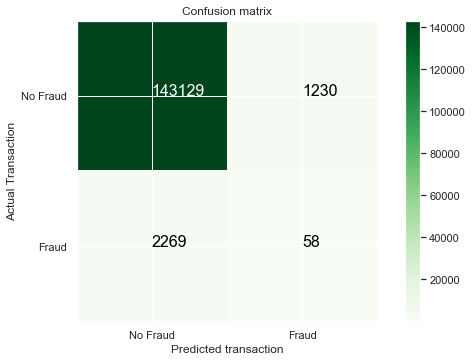

In [169]:
# Random Forest Confusion Matrix for Oversampled data
cm = confusion_matrix(y_test, oversample_rf_predicted_score) # y_test = Actual Transaction and oversample_rf_predicted_score =
# 'Predicted transaction'

plt.figure(figsize=(8,5))
confusion_matrix_plot(cm , labels=Class)
plt.show()

Oversampled Result / Logistic Regression Confusion Matrix:

The next cell is Logistic Regression Confusion Matrix for Oversampled data.

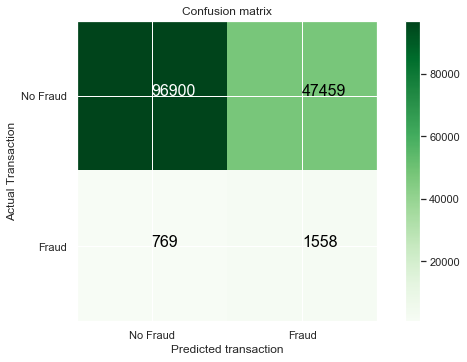

In [170]:
# logistic Regression Confusion Matrix for Oversampled data
cm = confusion_matrix(y_test, oversample_log_predicted_score)

plt.figure(figsize=(8,5))
plot_confusion_matrix(cm , labels=Class)
plt.show()

Oversampled Result / Logistic Regression ROC Curve:

The next cell is the Logistic Regression ROC curve for Oversampled data which calculates the sensitivity/specificity ratio. As I mentioned before, it does not measure well for imnalanced data. Because it does not emphasize on the minority class. But, I was curious to check it! 

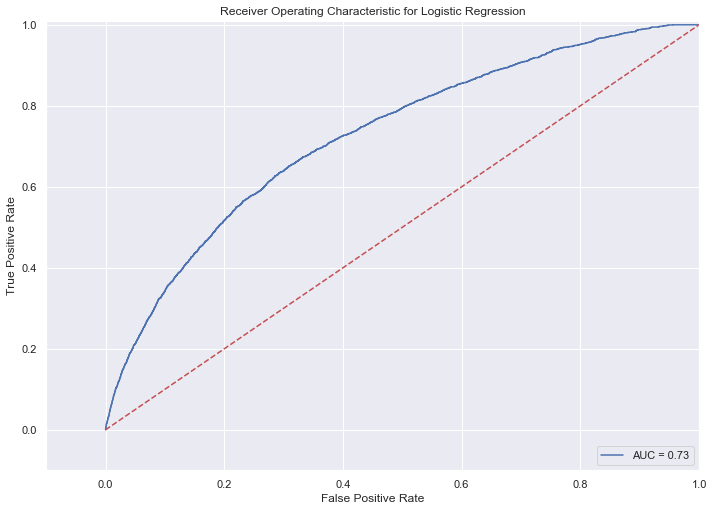

In [171]:
# Logistic Regression probabilities and converting them to 0 and 1 based on the threshold.  
y_score =  best_estimator_log.decision_function(X_test)
## Plot the ROC curve for Logistic Regression Oversampled Data
fpr, tpr, thresholds = roc_curve(y_test.ravel(),y_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Changing Thresholds for Oversampled Logistic Regression Model:

The predict function assigns predicted probabilities from sigmoid function and decides whether a record belongs to "1" or "0" based on 0.5 threshold. Here, I changed the threshold to assign a record to class 1 to have more control over recall or precision. I changed the threshhold of Logistic Regression by using predict_proba. But, interpreting the result depends on the domain and the problem's objective, if we prefer to have more FP or FN. 

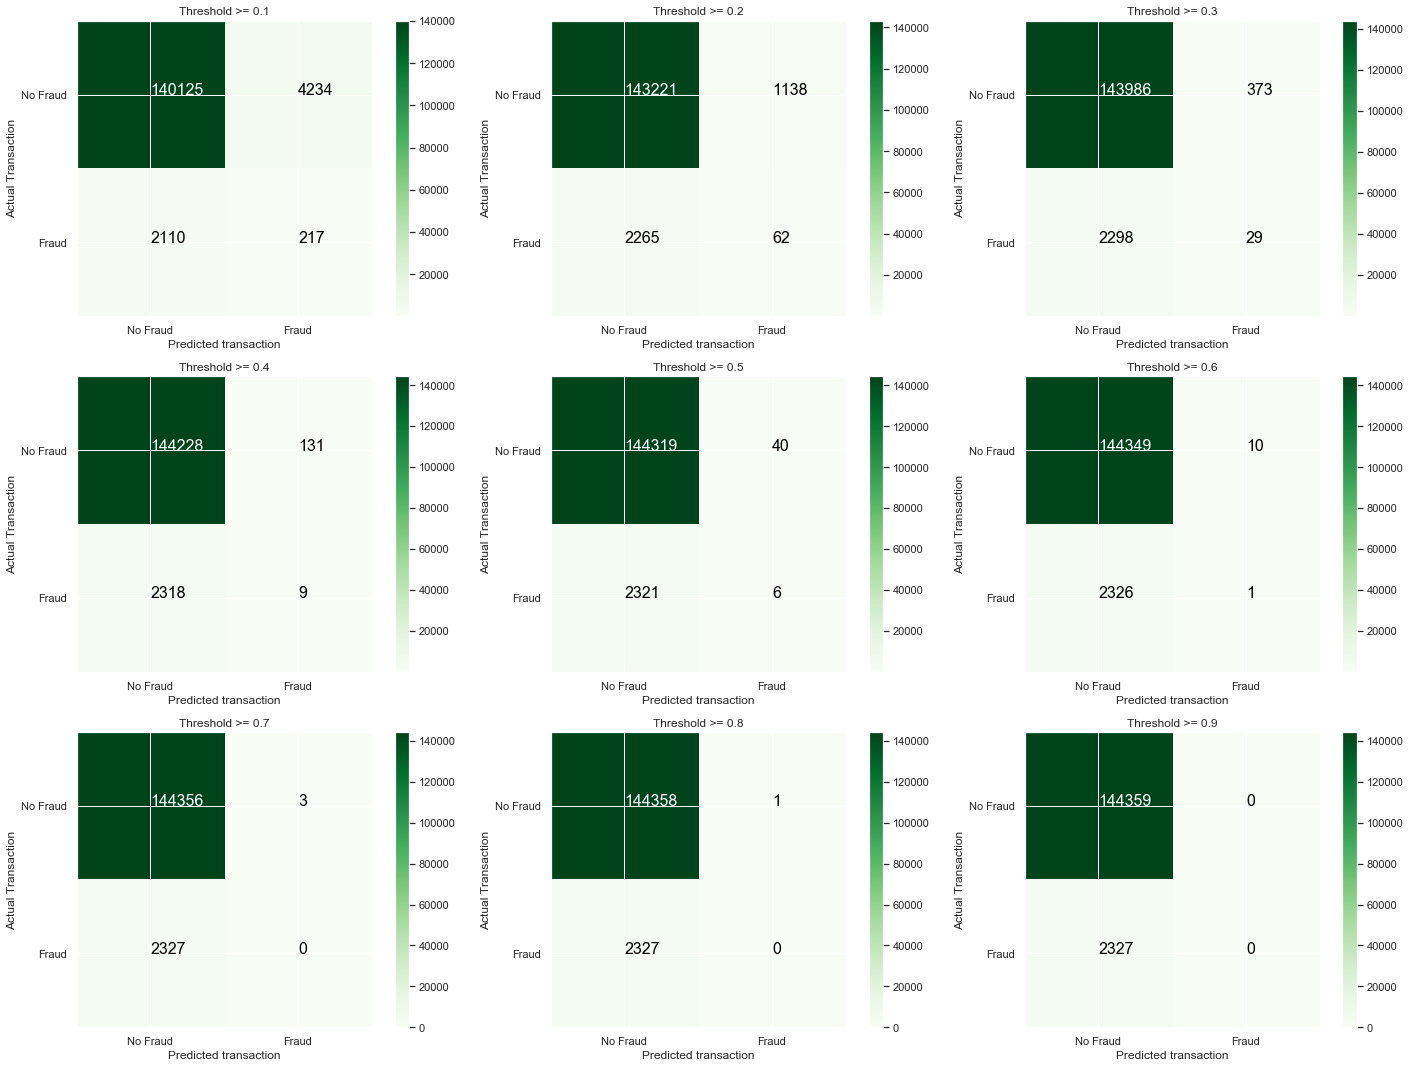

In [191]:
# fit the best model 
best_estimator_rf.fit(X_train,y_train.ravel())
# fit the best model and predict y_test classes using predict_prob
y_pred = best_estimator_rf.predict_proba(X_test)

# change the threshold to assign a record to class 1
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(20,15))

i = 1
for j in thresholds:
    y_test_pred = y_pred[:,1] > j
    
    plt.subplot(3,3,i)
    i += 1
    
    # Compute confusion matrix
    cm_matrix = confusion_matrix(y_test,y_test_pred)
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    confusion_matrix_plot(cm_matrix, labels=Class, title='Threshold >= %s'%j) 

Step 5) Potential Improvements  

As it was mentioned in the previous section, the models don't perform well even with undersampling the no fraud transactions and oversampling fraud cases. The following is what I would like to try to improve the model's performance if I had more time:

1)Implementing a better outlier detection in numerical variables like transactional amount, current balance and available money.
2)Engineering more features, for example, "merchantName". 
3)Apply other sampling techniques for example "TomekLinks".
4)If positiveness is defined as being Fraud, and we are interested to lower FP cases, we should penalize the no fraud loss function cases more. And, if lower FN is the objective, we might achieve it by penalizing fraud error more. 
5)I believe to classify fraud transactions from nonfraud transactions, we have to collect more data and add more predictors if possible.
